### The challenge is to predict the probability of loan disbursal for the customers of happy customer bank

http://datahack.analyticsvidhya.com/contest/data-hackathon-3x

In [16]:
import xgboost 
#from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [12]:
!conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import datetime
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as SklearnLinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn import metrics
from sklearn.decomposition import PCA
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

In [3]:
#open train set
train_set_path = "./data/Train.csv"
train_set = pd.read_csv(train_set_path, encoding='latin1')
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


##### We will be looking for numerical an categorical variables

In [4]:
target = 'Disbursed'
num_features = []
cat_features = []

In [5]:
#open train set
test_set_path = "./data/Test.csv"
test_set = pd.read_csv(test_set_path, encoding='latin1')
test_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
0,ID000026A10,Male,Dehradun,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,100000.0,3.0,20.0,1000.0,2649.39,N,Web-browser,B,S122,3
1,ID000054C40,Male,Mumbai,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,690000.0,5.0,24.0,13800.0,19849.90,Y,Mobile,C,S133,5
2,ID000066O10,Female,Jaipur,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
3,ID000110G00,Female,Chennai,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S133,1
4,ID000113J30,Male,Chennai,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,100000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S143,1


<AxesSubplot:title={'center':'Disbursed- Loan Disbursed (Target Variable)'}, ylabel='Disbursed'>

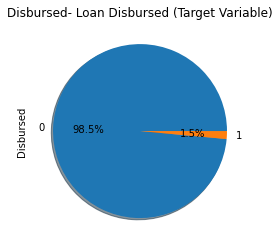

In [6]:
train_set['Disbursed'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, title="Disbursed- Loan Disbursed (Target Variable)")

#### unbalanced dataset!

## Input variables analysis

## Gender

Text(0.5, 1.0, 'test set gender distribution')

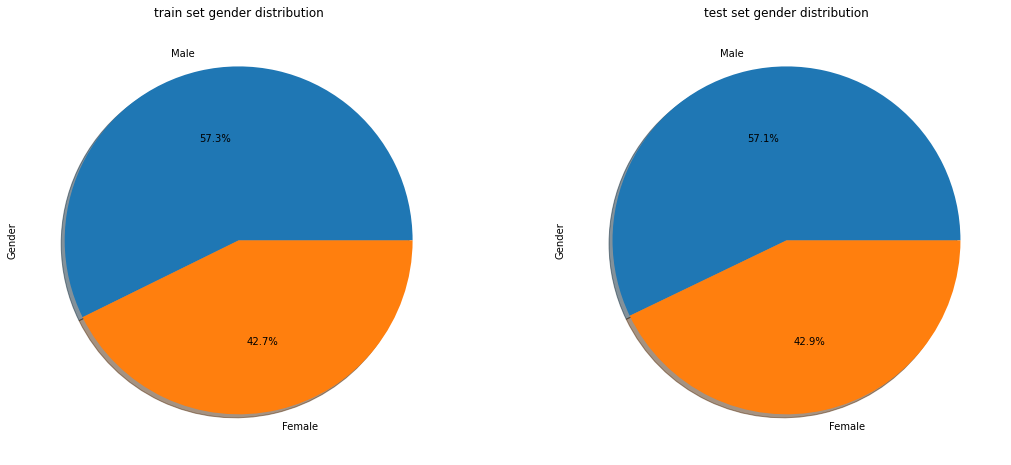

In [7]:
f, ax = plt.subplots(1,2,figsize=(18,8))
train_set['Gender'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title("train set gender distribution")

test_set['Gender'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True)
ax[1].set_title("test set gender distribution")

###### Gender distributions in train-test sets are the same

In [8]:
pd.isnull(train_set['Gender']).value_counts()

False    87020
Name: Gender, dtype: int64

In [9]:
cat_features.append('Gender')

## City

In [10]:
print("Counting of unique values in Cities")
print(train_set.City.value_counts())

Counting of unique values in Cities
Delhi          12527
Bengaluru      10824
Mumbai         10795
Hyderabad       7272
Chennai         6916
               ...  
GANDEVI            1
SILVASA            1
Imphal East        1
Mandla             1
Kannauj            1
Name: City, Length: 697, dtype: int64


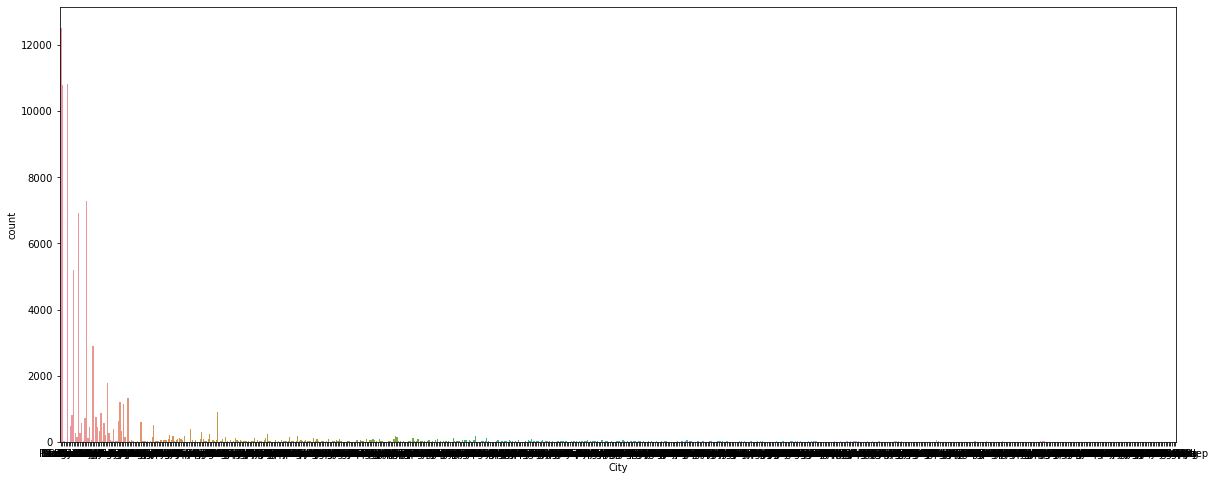

In [11]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "City", data = train_set)
plt.show()

In [12]:
print("How many unique values are in Cities column:")
print(len(train_set.City.value_counts()))

How many unique values are in Cities column:
697


In [13]:
print("Counting of unique values in Cities")
print(train_set.City.value_counts()[:10])

Counting of unique values in Cities
Delhi        12527
Bengaluru    10824
Mumbai       10795
Hyderabad     7272
Chennai       6916
Pune          5207
Kolkata       2888
Ahmedabad     1788
Jaipur        1331
Gurgaon       1212
Name: City, dtype: int64


In [14]:
print("Counting of unique values in Cities")
print(train_set.City.value_counts()[:10])

Counting of unique values in Cities
Delhi        12527
Bengaluru    10824
Mumbai       10795
Hyderabad     7272
Chennai       6916
Pune          5207
Kolkata       2888
Ahmedabad     1788
Jaipur        1331
Gurgaon       1212
Name: City, dtype: int64


#### Does data set has the same values in train and test set

In [15]:
set(train_set.City.value_counts().index.tolist()) == set(test_set.City.value_counts().index.tolist())

False

In [16]:
print("Counting of unique values in Cities // test")
print(test_set.City.value_counts()[:10])

Counting of unique values in Cities // test
Delhi        5409
Bengaluru    4698
Mumbai       4630
Hyderabad    3138
Chennai      2979
Pune         2220
Kolkata      1394
Ahmedabad     740
Jaipur        561
Gurgaon       531
Name: City, dtype: int64


#### Are bigger cities the same?

In [17]:
set(train_set.City.value_counts()[:5].index.tolist()) == set(test_set.City.value_counts()[:5].index.tolist())

True

In [18]:
big_cities = train_set.City.value_counts()[:5].index.tolist()

In [19]:
smaller_cities = train_set.City.value_counts()[1:].index.tolist()

#### There is too many cathegories in <b>City</b> column 

In [20]:
train_set['City'].replace(big_cities,1, inplace = True)
train_set['City'].replace(smaller_cities,0, inplace = True)
train_set['City'].value_counts()

1.0    48334
0.0    37683
Name: City, dtype: int64

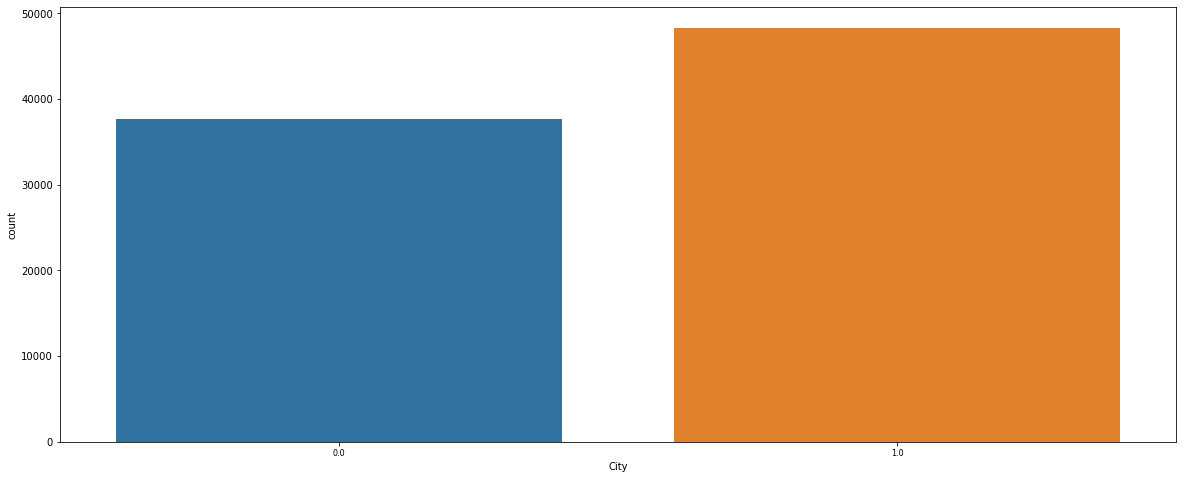

In [21]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "City", data = train_set)
plt.show()

In [22]:
smaller_cities = test_set.City.value_counts()[1:].index.tolist()
test_set['City'].replace(big_cities,1, inplace = True)
test_set['City'].replace(smaller_cities,0, inplace = True)
test_set['City'].value_counts()

1.0    20854
0.0    16465
Name: City, dtype: int64

#### Missing values

In [23]:
pd.isnull(train_set['City']).value_counts()

False    86017
True      1003
Name: City, dtype: int64

In [24]:
train_set['City'].fillna(0, inplace = True)
test_set['City'].fillna(0, inplace = True)

In [25]:
num_features.append('City')

### Monthly_Income - Monthly Income in rupees

Text(0.5, 0, 'Monthly_Income')

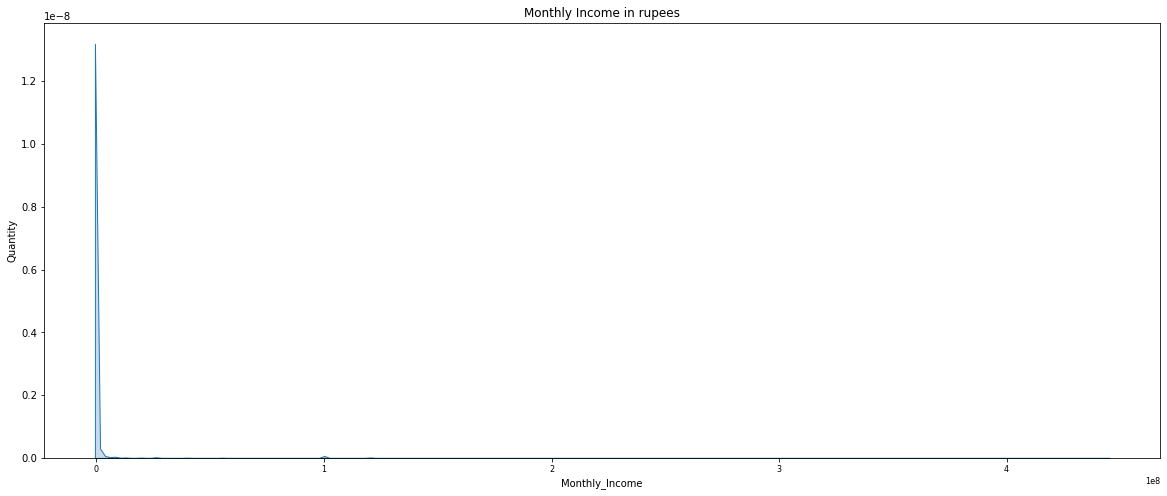

In [26]:
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=train_set['Monthly_Income'], shade=True)
plt.title("Monthly Income in rupees")
plt.ylabel('Quantity')
plt.xlabel('Monthly_Income')

Average monthy income in TRAIN set : 58850.0
Average monthy income in TEST set : 39803.0 ; difference:  19047.0


Text(0.5, 0, 'Monthly_Income')

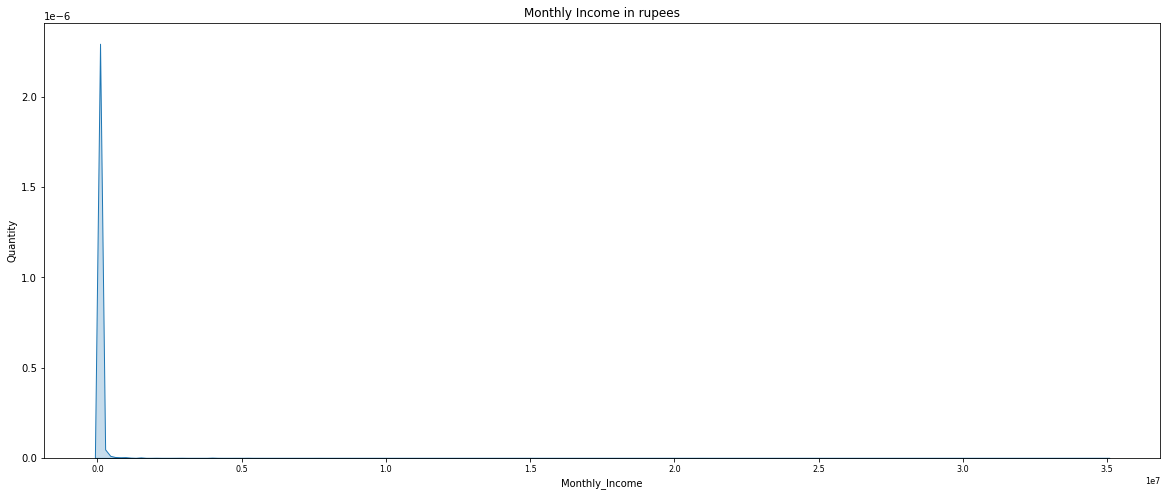

In [27]:
print("Average monthy income in TRAIN set :", np.round(train_set['Monthly_Income'].mean(),0))
print("Average monthy income in TEST set :", 
      np.round(test_set['Monthly_Income'].mean(),0), 
      "; difference: ", 
      np.round(train_set['Monthly_Income'].mean(),0) - np.round(test_set['Monthly_Income'].mean(),0)) 
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=test_set['Monthly_Income'], shade=True)
plt.title("Monthly Income in rupees")
plt.ylabel('Quantity')
plt.xlabel('Monthly_Income')

#### Missing income

In [28]:
pd.isnull(train_set['Monthly_Income']).value_counts()

False    87020
Name: Monthly_Income, dtype: int64

In [29]:
num_features.append('Monthly_Income')

### DOB - Date of Birth

In [30]:
pd.isnull(train_set['DOB']).value_counts()

False    87020
Name: DOB, dtype: int64

In [31]:
def from_dob_to_age(born):
    today = datetime.date.today()
    if (born.year > today.year):
        return today.year - (born.year-100) - ((today.month, today.day) < (born.month, born.day))
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [32]:
train_set['Age']=train_set["DOB"].apply(lambda x: from_dob_to_age(datetime.datetime.strptime(x, '%d-%b-%y')))

In [33]:
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age
0,ID000002C20,Female,1.0,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,N,Web-browser,G,S122,1,0,0,43
1,ID000004E40,Male,1.0,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,NaN,6762.9,N,Web-browser,G,S122,3,0,0,36
2,ID000007H20,Male,0.0,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,N,Web-browser,B,S143,1,0,0,40
3,ID000008I30,Male,0.0,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,N,Web-browser,B,S143,3,0,0,33
4,ID000009J40,Male,1.0,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,N,Web-browser,B,S134,3,1,0,37


Text(0.5, 0, 'Age')

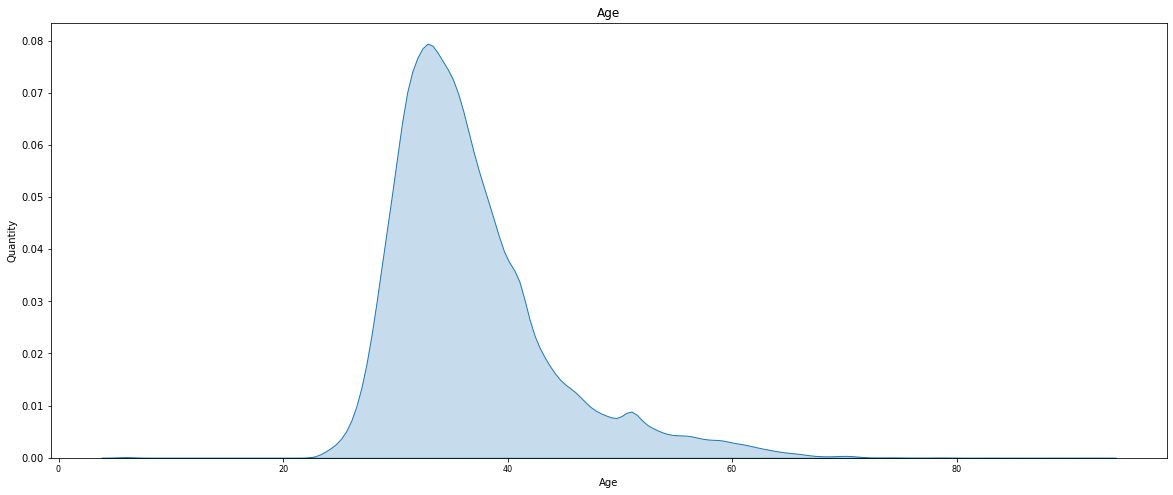

In [34]:
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=train_set['Age'], shade=True)
plt.title("Age")
plt.ylabel('Quantity')
plt.xlabel('Age')

In [35]:
train_set.loc[train_set['Age'] < 0]

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age


In [36]:
test_set['Age']=test_set["DOB"].apply(lambda x: from_dob_to_age(datetime.datetime.strptime(x, '%d-%b-%y')))

Text(0.5, 0, 'Age')

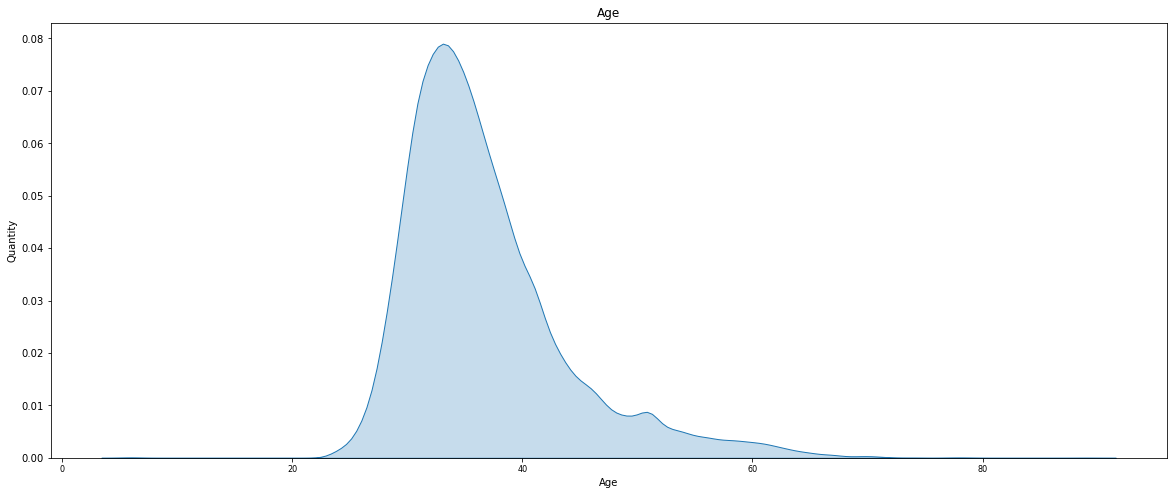

In [37]:
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=test_set['Age'], shade=True)
plt.title("Age")
plt.ylabel('Quantity')
plt.xlabel('Age')

### Lead_Creation_Date - Lead Created on date

In [38]:
pd.isnull(train_set['Lead_Creation_Date']).value_counts()

False    87020
Name: Lead_Creation_Date, dtype: int64

In [39]:
def from_date_to_yr(date):
    today = datetime.date.today()
    return today.year - date.year - ((today.month, today.day) < (date.month, date.day))

In [40]:
train_set['Yrs_Lead_Creation_Date']=train_set["Lead_Creation_Date"].apply(lambda x: from_date_to_yr(datetime.datetime.strptime(x, '%d-%b-%y')))

In [41]:
train_set 

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date
0,ID000002C20,Female,1.0,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,N,Web-browser,G,S122,1,0,0,43,6
1,ID000004E40,Male,1.0,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,6762.90,N,Web-browser,G,S122,3,0,0,36,6
2,ID000007H20,Male,0.0,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,N,Web-browser,B,S143,1,0,0,40,6
3,ID000008I30,Male,0.0,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,N,Web-browser,B,S143,3,0,0,33,6
4,ID000009J40,Male,1.0,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,N,Web-browser,B,S134,3,1,0,37,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,ID124813N30,Female,0.0,71901,27-Nov-69,31-Jul-15,1000000.0,5.0,14500.0,MAYO COLLEGE,...,NaN,N,Web-browser,G,S122,3,0,0,51,6
87016,ID124814O40,Female,0.0,16000,01-Dec-90,31-Jul-15,0.0,0.0,0.0,KERALA COMMUNICATORS CABLE LTD,...,9425.76,Y,Mobile,G,S122,5,0,0,30,6
87017,ID124816Q10,Male,1.0,118000,28-Jan-72,31-Jul-15,0.0,0.0,0.0,BANGALORE INSTITUTE OF TECHNOLOGY,...,NaN,N,Mobile,G,S122,3,0,0,49,6
87018,ID124818S30,Male,1.0,98930,27-Apr-77,31-Jul-15,800000.0,5.0,13660.0,FIRSTSOURCE SOLUTION LTD,...,NaN,N,Web-browser,G,S122,3,0,0,44,6


In [42]:
test_set['Yrs_Lead_Creation_Date']=test_set["Lead_Creation_Date"].apply(lambda x: from_date_to_yr(datetime.datetime.strptime(x, '%d-%b-%y')))

#### All application were created 6 yr ago

#### Date of applying seems to be meaningless variable to the prediction:

In [43]:
train_set = train_set.drop(['Lead_Creation_Date'], axis=1)

### I'll create one combine variable for Age when someone tooke the loan

In [44]:
train_set['Age_Creation_Date'] = train_set['Age'] - train_set['Yrs_Lead_Creation_Date']

Text(0.5, 0, 'Age_Creation_Date')

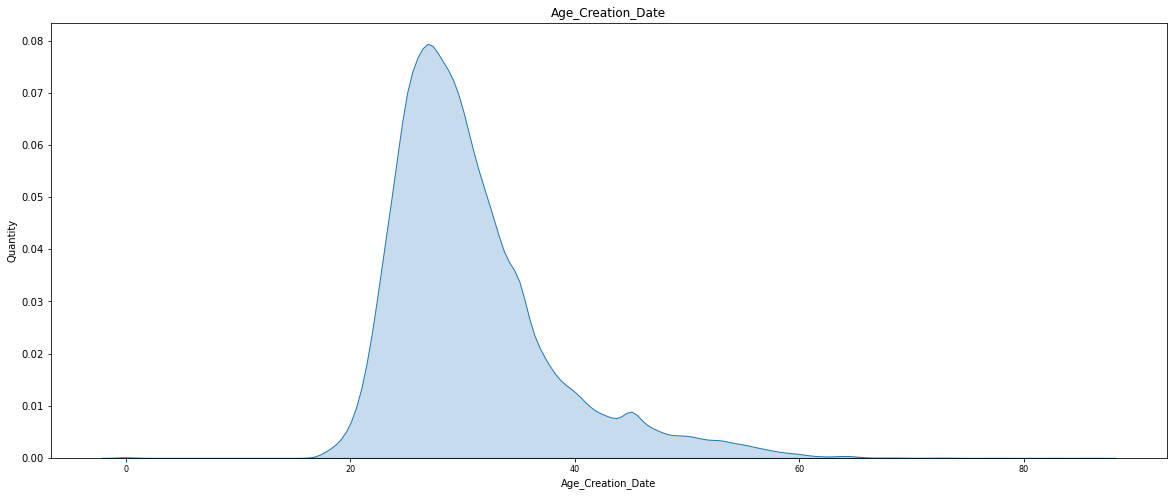

In [45]:
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=train_set['Age_Creation_Date'], shade=True)
plt.title("Age_Creation_Date")
plt.ylabel('Quantity')
plt.xlabel('Age_Creation_Date')

In [46]:
test_set['Age_Creation_Date'] = test_set['Age'] -test_set['Yrs_Lead_Creation_Date']

Text(0.5, 0, 'Age_Creation_Date')

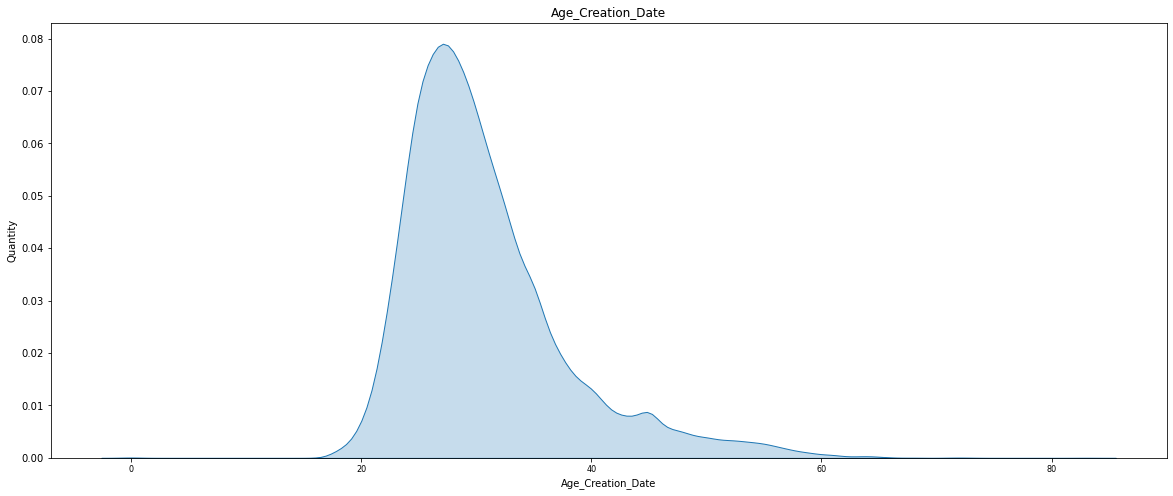

In [47]:
fig = plt.figure(figsize=(20,8))
sns.kdeplot(data=test_set['Age_Creation_Date'], shade=True)
plt.title("Age_Creation_Date")
plt.ylabel('Quantity')
plt.xlabel('Age_Creation_Date')

In [48]:
train_set.loc[train_set['Age_Creation_Date'] < 0]

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date


In [49]:
num_features.append('Age_Creation_Date')

### Loan_Amount_Applied - Loan Amount Requested (INR)

##### INR – INDIAN RUPEE

Loan Amount Requested (INR) : 230251.0


Text(0.5, 0, 'Loan_Amount_Applied')

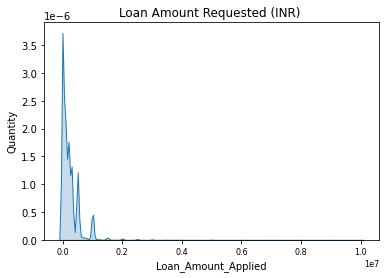

In [50]:
print("Loan Amount Requested (INR) :", np.round(train_set['Loan_Amount_Applied'].mean(),0))
sns.kdeplot(data=train_set['Loan_Amount_Applied'], shade=True)
plt.title("Loan Amount Requested (INR) ")
plt.ylabel('Quantity')
plt.xlabel('Loan_Amount_Applied')

In [51]:
pd.isnull(train_set['Loan_Amount_Applied']).value_counts()

False    86949
True        71
Name: Loan_Amount_Applied, dtype: int64

In [52]:
train_set['Loan_Amount_Applied'].quantile(.1)

0.0

In [53]:
train_set['Loan_Amount_Applied'].describe()

count    8.694900e+04
mean     2.302507e+05
std      3.542068e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+05
75%      3.000000e+05
max      1.000000e+07
Name: Loan_Amount_Applied, dtype: float64

In [54]:
train_set['Loan_Amount_Applied'].quantile([.25, .5, .75, 0.95])

0.25          0.0
0.50     100000.0
0.75     300000.0
0.95    1000000.0
Name: Loan_Amount_Applied, dtype: float64

In [55]:
Loan_Amount_Applied_labels = ['small', 'medium', 'big']
train_set['Loan_Amount_Applied_cut'] = pd.qcut(train_set['Loan_Amount_Applied'],
                              q=[0, .5, .75, 1],
                              labels=Loan_Amount_Applied_labels)
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut
0,ID000002C20,Female,1.0,20000,23-May-78,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,...,Web-browser,G,S122,1,0,0,43,6,37,medium
1,ID000004E40,Male,1.0,35000,07-Oct-85,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,...,Web-browser,G,S122,3,0,0,36,6,30,medium
2,ID000007H20,Male,0.0,22500,10-Oct-81,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,...,Web-browser,B,S143,1,0,0,40,6,34,big
3,ID000008I30,Male,0.0,35000,30-Nov-87,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,...,Web-browser,B,S143,3,0,0,33,6,27,big
4,ID000009J40,Male,1.0,100000,17-Feb-84,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,...,Web-browser,B,S134,3,1,0,37,6,31,big


In [56]:
train_set.tail(3)

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut
87017,ID124816Q10,Male,1.0,118000,28-Jan-72,0.0,0.0,0.0,BANGALORE INSTITUTE OF TECHNOLOGY,Syndicate Bank,...,Mobile,G,S122,3,0,0,49,6,43,small
87018,ID124818S30,Male,1.0,98930,27-Apr-77,800000.0,5.0,13660.0,FIRSTSOURCE SOLUTION LTD,ICICI Bank,...,Web-browser,G,S122,3,0,0,44,6,38,big
87019,ID124821V10,Male,1.0,42300,31-Oct-88,0.0,0.0,0.0,GOVERNMENT OF INDIA,NaN,...,Web-browser,G,S122,4,0,0,33,6,27,small


In [57]:
train_set['Loan_Amount_Applied_cut']

0        medium
1        medium
2           big
3           big
4           big
          ...  
87015       big
87016     small
87017     small
87018       big
87019     small
Name: Loan_Amount_Applied_cut, Length: 87020, dtype: category
Categories (3, object): ['small' < 'medium' < 'big']

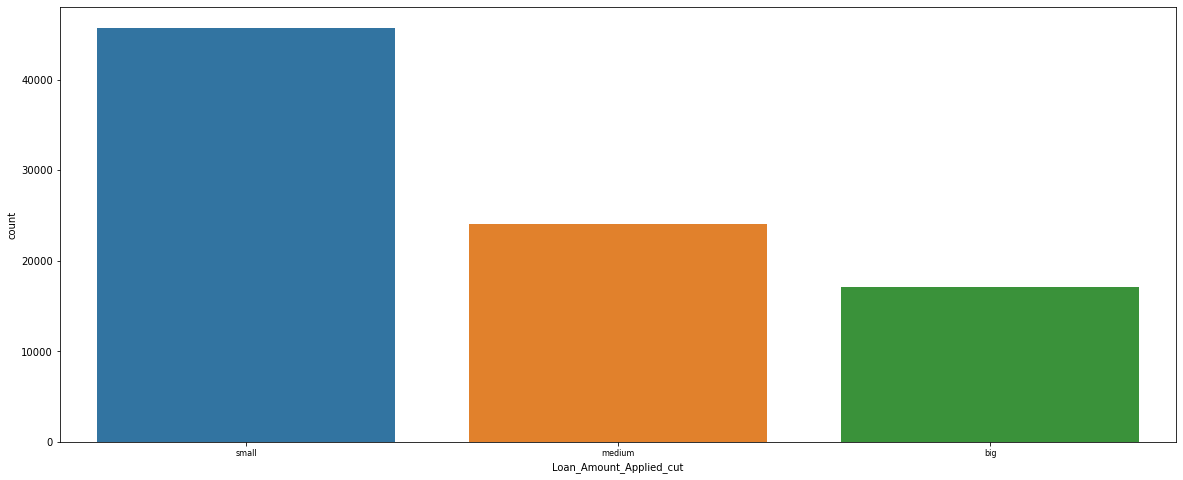

In [58]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Applied_cut", data = train_set)
plt.show()

Loan Amount Requested (INR) : 229389.0


Text(0.5, 0, 'Loan_Amount_Applied')

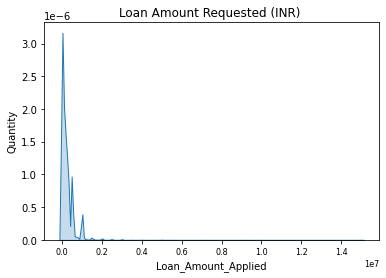

In [59]:
print("Loan Amount Requested (INR) :", np.round(test_set['Loan_Amount_Applied'].mean(),0))
sns.kdeplot(data=test_set['Loan_Amount_Applied'], shade=True)
plt.title("Loan Amount Requested (INR) ")
plt.ylabel('Quantity')
plt.xlabel('Loan_Amount_Applied')

In [60]:
test_set['Loan_Amount_Applied'].describe()

count    3.767700e+04
mean     2.293886e+05
std      3.539572e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+05
75%      3.000000e+05
max      1.500000e+07
Name: Loan_Amount_Applied, dtype: float64

In [61]:
Loan_Amount_Applied_labels = ['small', 'medium', 'big']
test_set['Loan_Amount_Applied_cut'] = pd.qcut(test_set['Loan_Amount_Applied'],
                              q=[0, .5, .75, 0.95],
                              labels=Loan_Amount_Applied_labels)
test_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut
0,ID000026A10,Male,0.0,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,2649.39,N,Web-browser,B,S122,3,34,6,28,small
1,ID000054C40,Male,1.0,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,19849.90,Y,Mobile,C,S133,5,41,6,35,small
2,ID000066O10,Female,0.0,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,N,Web-browser,B,S133,1,32,6,26,medium
3,ID000110G00,Female,1.0,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,N,Mobile,C,S133,1,30,6,24,small
4,ID000113J30,Male,1.0,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,NaN,N,Web-browser,B,S143,1,34,6,28,small


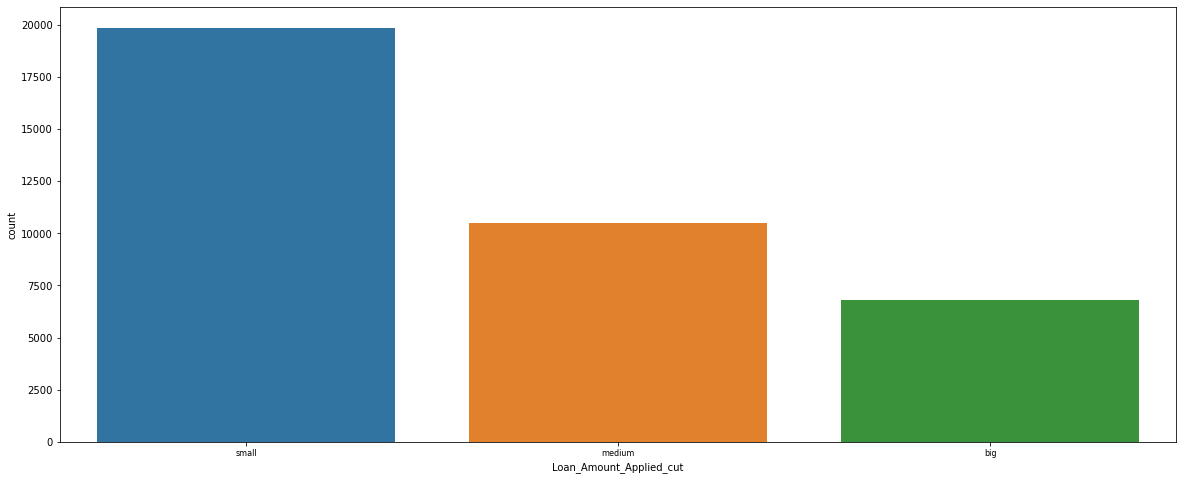

In [62]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Applied_cut", data = test_set)
plt.show()

In [63]:
pd.isnull(test_set['Loan_Amount_Applied_cut']).value_counts()

False    37146
True       571
Name: Loan_Amount_Applied_cut, dtype: int64

In [64]:
pd.isnull(train_set['Loan_Amount_Applied_cut']).value_counts()

False    86949
True        71
Name: Loan_Amount_Applied_cut, dtype: int64

#### I'll change missing values, beacuse it's seems to be key variable

In [65]:
train_set['Loan_Amount_Applied_cut'] = train_set['Loan_Amount_Applied_cut'].cat.add_categories('unknown')
test_set['Loan_Amount_Applied_cut'] = test_set['Loan_Amount_Applied_cut'].cat.add_categories('unknown')
train_set['Loan_Amount_Applied_cut'].fillna("unknown", inplace = True)
test_set['Loan_Amount_Applied_cut'].fillna("unknown", inplace = True)

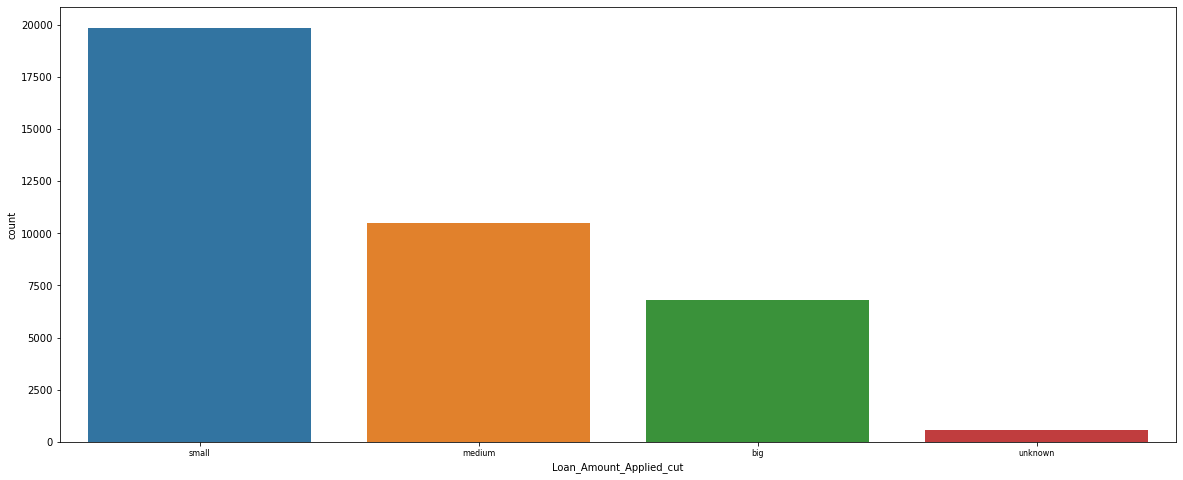

In [66]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Applied_cut", data = test_set)
plt.show()

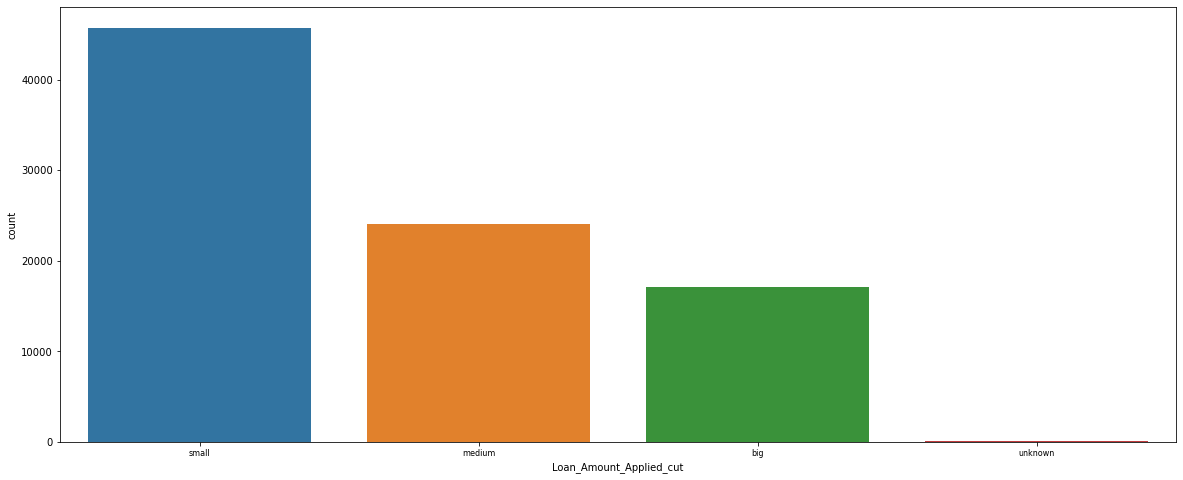

In [67]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Applied_cut", data = train_set)
plt.show()

In [68]:
cat_features.append('Loan_Amount_Applied_cut')

### Loan_Tenure_Applied - Loan Tenure Requested (in years)

Loan Tenure Requested (in years) : 2.0


Text(0.5, 0, 'Loan_Tenure_Applied')

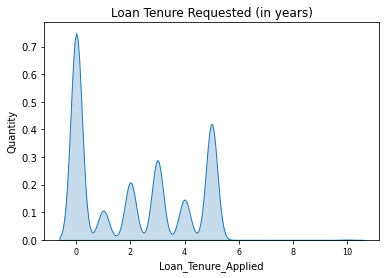

In [69]:
print("Loan Tenure Requested (in years) :", np.round(train_set['Loan_Tenure_Applied'].mean(),0))
sns.kdeplot(data=train_set['Loan_Tenure_Applied'], shade=True)
plt.title("Loan Tenure Requested (in years)")
plt.ylabel('Quantity')
plt.xlabel('Loan_Tenure_Applied')

In [70]:
train_set['Loan_Tenure_Applied'].describe()

count    86949.000000
mean         2.131399
std          2.014193
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: Loan_Tenure_Applied, dtype: float64

In [71]:
pd.isnull(train_set['Loan_Tenure_Applied']).value_counts()

False    86949
True        71
Name: Loan_Tenure_Applied, dtype: int64

In [72]:
train_set['Loan_Tenure_Applied'].quantile([0, 0.3, 0.4,.25, .5, .75, 1])

0.00     0.0
0.30     0.0
0.40     1.0
0.25     0.0
0.50     2.0
0.75     4.0
1.00    10.0
Name: Loan_Tenure_Applied, dtype: float64

In [73]:
Loan_Tenure_Applied_labels = ['small', 'medium', 'big']
train_set['Loan_Tenure_Applied_cut'] = pd.qcut(train_set['Loan_Tenure_Applied'],
                              q=[0, 0.4, .75, 1],
                              labels=Loan_Tenure_Applied_labels)
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Var2,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut,Loan_Tenure_Applied_cut
0,ID000002C20,Female,1.0,20000,23-May-78,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,...,G,S122,1,0,0,43,6,37,medium,big
1,ID000004E40,Male,1.0,35000,07-Oct-85,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,...,G,S122,3,0,0,36,6,30,medium,medium
2,ID000007H20,Male,0.0,22500,10-Oct-81,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,...,B,S143,1,0,0,40,6,34,big,medium
3,ID000008I30,Male,0.0,35000,30-Nov-87,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,...,B,S143,3,0,0,33,6,27,big,big
4,ID000009J40,Male,1.0,100000,17-Feb-84,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,...,B,S134,3,1,0,37,6,31,big,medium


In [74]:
train_set['Loan_Tenure_Applied_cut'] = train_set['Loan_Tenure_Applied_cut'].cat.add_categories('unknown')
train_set['Loan_Tenure_Applied_cut'].fillna("unknown", inplace = True)

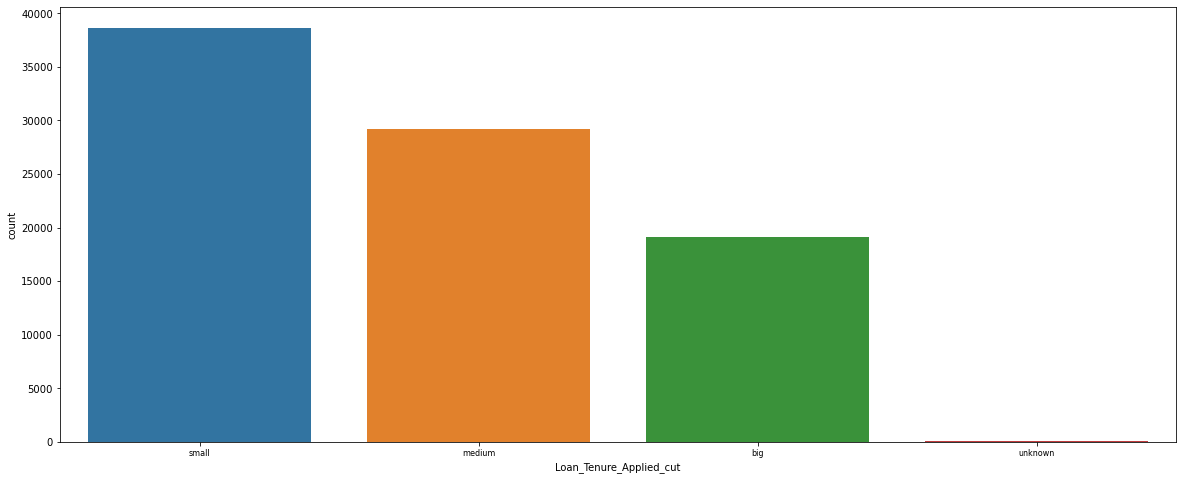

In [75]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Tenure_Applied_cut", data = train_set)
plt.show()

In [76]:
Loan_Tenure_Applied_labels = ['small', 'medium', 'big']
test_set['Loan_Tenure_Applied_cut'] = pd.qcut(test_set['Loan_Tenure_Applied'],
                              q=[0, .4, .75, 1],
                              labels=Loan_Tenure_Applied_labels)
test_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Filled_Form,Device_Type,Var2,Source,Var4,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut,Loan_Tenure_Applied_cut
0,ID000026A10,Male,0.0,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,N,Web-browser,B,S122,3,34,6,28,small,medium
1,ID000054C40,Male,1.0,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,Y,Mobile,C,S133,5,41,6,35,small,small
2,ID000066O10,Female,0.0,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,N,Web-browser,B,S133,1,32,6,26,medium,medium
3,ID000110G00,Female,1.0,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,N,Mobile,C,S133,1,30,6,24,small,small
4,ID000113J30,Male,1.0,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,N,Web-browser,B,S143,1,34,6,28,small,small


In [77]:
test_set['Loan_Tenure_Applied_cut'] = test_set['Loan_Tenure_Applied_cut'].cat.add_categories('unknown')
test_set['Loan_Tenure_Applied_cut'].fillna("unknown", inplace = True)

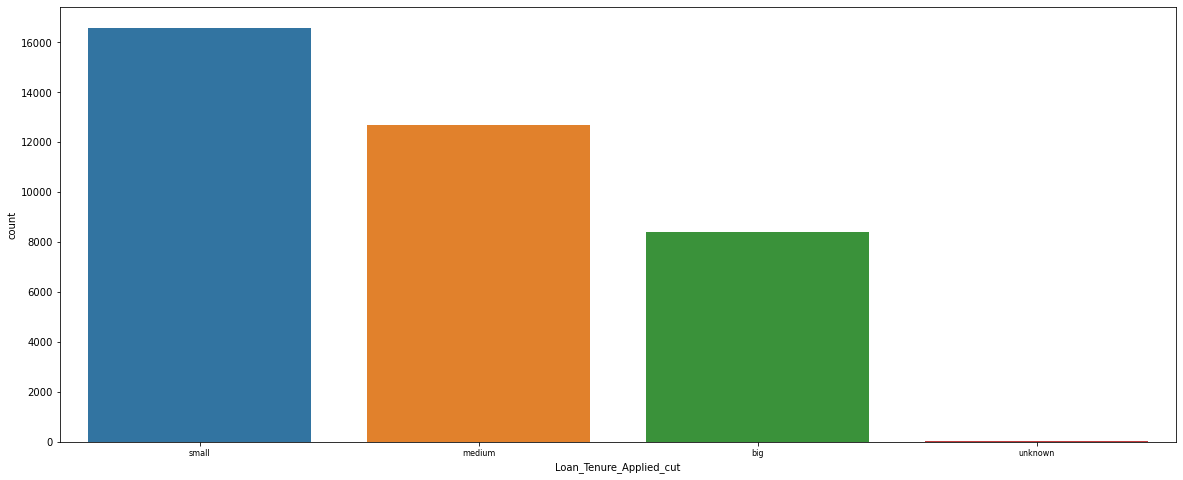

In [78]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Tenure_Applied_cut", data = test_set)
plt.show()

In [79]:
cat_features.append('Loan_Tenure_Applied_cut')

### Existing_EMI - EMI of Existing Loans (INR)

##### What Is an Equated Monthly Installment (EMI)?
An equated monthly installment (EMI) is a fixed payment amount made by a borrower to a lender at a specified date each calendar month. Equated monthly installments are applied to both interest and principal each month so that over a specified number of years, the loan is paid off in full.

EMI of Existing Loans (INR) : 3696.0


Text(0.5, 0, 'Existing_EMI')

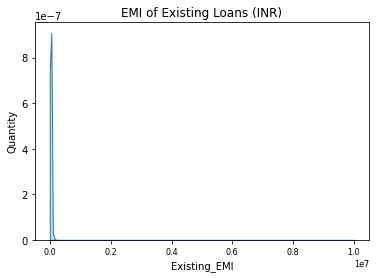

In [80]:
print("EMI of Existing Loans (INR) :", np.round(train_set['Existing_EMI'].mean(),0))
sns.kdeplot(data=train_set['Existing_EMI'], shade=True)
plt.title("EMI of Existing Loans (INR)")
plt.ylabel('Quantity')
plt.xlabel('Existing_EMI')

In [81]:
train_set['Existing_EMI'].head(10)

0        0.0
1        0.0
2        0.0
3        0.0
4    25000.0
5    15000.0
6        0.0
7     2597.0
8        0.0
9        0.0
Name: Existing_EMI, dtype: float64

In [82]:
sex_disbursed = pd.DataFrame({'EMI': train_set['Existing_EMI'], 'disbursed': train_set.Disbursed})
data = sex_disbursed.disbursed.groupby([sex_disbursed.disbursed, sex_disbursed.EMI]).size()
print(data)

disbursed  EMI     
0          0.0         57600
           1.0            43
           1.5             1
           2.0            13
           3.0             6
                       ...  
1          77000.0         1
           90000.0         2
           94000.0         2
           95000.0         1
           300000.0        1
Name: disbursed, Length: 3937, dtype: int64


### Disbursed loan has no influence on EMI

In [83]:
pd.isnull(train_set['Existing_EMI']).sum()

71

In [84]:
train_set.Disbursed[pd.isnull(train_set['Existing_EMI'])].mean()

0.028169014084507043

In [85]:
train_set['Existing_EMI'].describe()

count    8.694900e+04
mean     3.696228e+03
std      3.981021e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+03
max      1.000000e+07
Name: Existing_EMI, dtype: float64

In [86]:
train_set['Existing_EMI'].quantile([0, 0.5, 0.67 ,0.75, 0.8, 0.9, 0.95, 0.99999, 1])

0.00000    0.000000e+00
0.50000    0.000000e+00
0.67000    1.000000e+00
0.75000    3.500000e+03
0.80000    5.000000e+03
0.90000    1.000000e+04
0.95000    1.800000e+04
0.99999    6.047661e+06
1.00000    1.000000e+07
Name: Existing_EMI, dtype: float64

In [87]:
emi_labels = ['small', 'medium', 'big']
train_set['Existing_EMI_cut'] = pd.qcut(train_set['Existing_EMI'],
                              q=[0, .67, 0.95, 1],
                              labels=emi_labels)
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Source,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut,Loan_Tenure_Applied_cut,Existing_EMI_cut
0,ID000002C20,Female,1.0,20000,23-May-78,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,...,S122,1,0,0,43,6,37,medium,big,small
1,ID000004E40,Male,1.0,35000,07-Oct-85,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,...,S122,3,0,0,36,6,30,medium,medium,small
2,ID000007H20,Male,0.0,22500,10-Oct-81,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,...,S143,1,0,0,40,6,34,big,medium,small
3,ID000008I30,Male,0.0,35000,30-Nov-87,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,...,S143,3,0,0,33,6,27,big,big,small
4,ID000009J40,Male,1.0,100000,17-Feb-84,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,...,S134,3,1,0,37,6,31,big,medium,big


In [88]:
train_set['Existing_EMI_cut'] = train_set['Existing_EMI_cut'].cat.add_categories('unknown')
train_set['Existing_EMI_cut'].fillna("unknown", inplace = True)

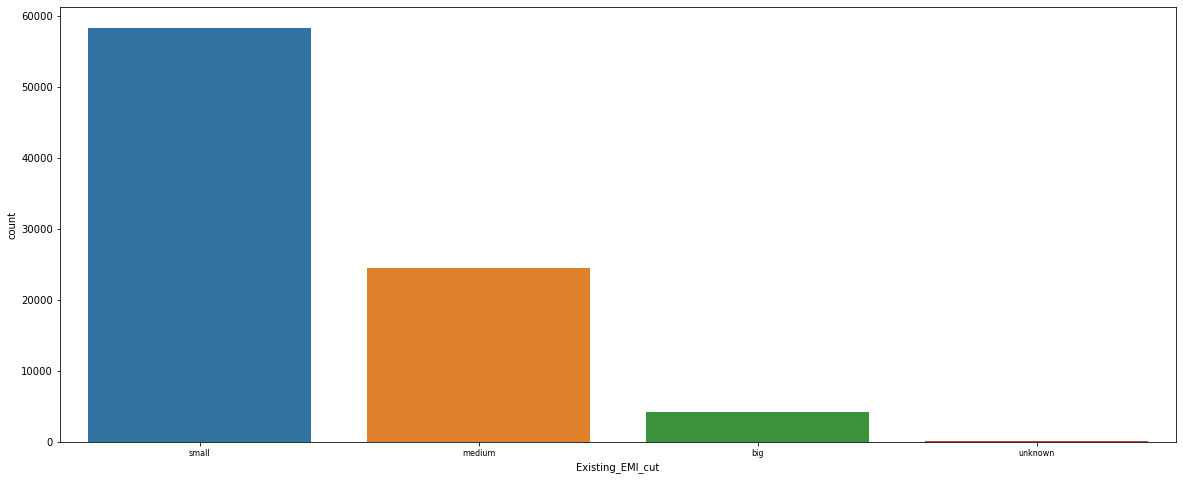

In [89]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Existing_EMI_cut", data = train_set)
plt.show()

In [90]:
emi_labels = ['small', 'medium', 'big']
test_set['Existing_EMI_cut'] = pd.qcut(test_set['Existing_EMI'],
                              q=[0, .67, 0.95, 1],
                              labels=emi_labels)
test_set.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Device_Type,Var2,Source,Var4,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut,Loan_Tenure_Applied_cut,Existing_EMI_cut
0,ID000026A10,Male,0.0,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,Web-browser,B,S122,3,34,6,28,small,medium,small
1,ID000054C40,Male,1.0,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,Mobile,C,S133,5,41,6,35,small,small,small
2,ID000066O10,Female,0.0,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,Web-browser,B,S133,1,32,6,26,medium,medium,small
3,ID000110G00,Female,1.0,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,Mobile,C,S133,1,30,6,24,small,small,small
4,ID000113J30,Male,1.0,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,Web-browser,B,S143,1,34,6,28,small,small,medium


In [91]:
test_set['Existing_EMI_cut'] = test_set['Existing_EMI_cut'].cat.add_categories('unknown')
test_set['Existing_EMI_cut'].fillna("unknown", inplace = True)

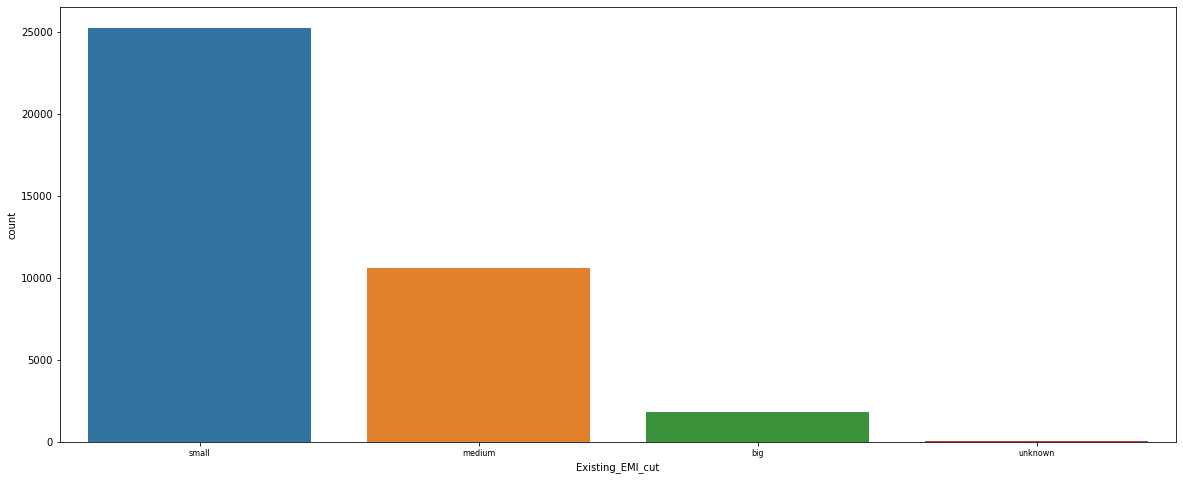

In [92]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Existing_EMI_cut", data = test_set)
plt.show()

In [93]:
cat_features.append('Existing_EMI_cut')

### Employer_Name - Employer Name

In [94]:
pd.isnull(train_set['Employer_Name']).value_counts()

False    86949
True        71
Name: Employer_Name, dtype: int64

In [95]:
train_set['Employer_Name'].unique()

array(['CYBOSOL', 'TATA CONSULTANCY SERVICES LTD (TCS)',
       'ALCHEMIST HOSPITALS LTD', ..., 'UTTAM VALUE STEEL LTD,WARDHA',
       'MAYO COLLEGE', 'BANGALORE INSTITUTE OF TECHNOLOGY'], dtype=object)

In [96]:
(train_set['Employer_Name'] == '0').sum()

4914

In [97]:
train_set['Employer_Name'].value_counts()

0                                               4914
TATA CONSULTANCY SERVICES LTD (TCS)              550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     404
ACCENTURE SERVICES PVT LTD                       324
GOOGLE                                           301
                                                ... 
ADVANCE HEAT TREATERS                              1
ICICI PRUDENTIAL LIFE INSURANCE COMPANY LTD        1
GOVT GIRLS HIGH SCHOOL                             1
WELCOMEINFRA ESTATE PVT.LTD                        1
BHARAT INSTITUTE OF TECHNOLOGY SONEPAT             1
Name: Employer_Name, Length: 43567, dtype: int64

##### There is missing values in Employer Name set as '0', I'll change it to others

In [98]:
train_set['Employer_Name'].replace('0','Other', inplace = True)

In [99]:
len(train_set['Employer_Name'].value_counts())

43566

In [100]:
print(train_set.Employer_Name.value_counts()[0:20])

Other                                           4925
TATA CONSULTANCY SERVICES LTD (TCS)              550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     404
ACCENTURE SERVICES PVT LTD                       324
GOOGLE                                           301
HCL TECHNOLOGIES LTD                             250
ICICI BANK LTD                                   239
INDIAN AIR FORCE                                 191
INFOSYS TECHNOLOGIES                             181
GENPACT                                          179
IBM CORPORATION                                  173
INDIAN ARMY                                      171
TYPE SLOWLY FOR AUTO FILL                        162
WIPRO TECHNOLOGIES                               155
HDFC BANK LTD                                    148
IKYA HUMAN CAPITAL SOLUTIONS LTD                 142
STATE GOVERNMENT                                 134
INDIAN RAILWAY                                   130
INDIAN NAVY                                   

In [101]:
a = train_set.Employer_Name.value_counts()[1:100].index.tolist()
train_set['Employer_Name'].replace(a,'huge', inplace = True)

In [102]:
b = train_set.Employer_Name.value_counts()[2:200].index.tolist()
train_set['Employer_Name'].replace(b,'big', inplace = True)

In [103]:
c = train_set.Employer_Name.value_counts()[3:].index.tolist()
train_set['Employer_Name'].replace(c,'small', inplace = True)

In [104]:
train_set['Employer_Name'].value_counts()

small    67653
huge      9106
big       5265
Other     4925
Name: Employer_Name, dtype: int64

In [105]:
cat_features.append('Employer_Name')

In [106]:
test_set['Employer_Name'].replace('0','Other', inplace = True)

In [107]:
a = test_set.Employer_Name.value_counts()[1:100].index.tolist()
test_set['Employer_Name'].replace(a,'huge', inplace = True)
b = test_set.Employer_Name.value_counts()[2:200].index.tolist()
test_set['Employer_Name'].replace(b,'big', inplace = True)
c = test_set.Employer_Name.value_counts()[3:].index.tolist()
test_set['Employer_Name'].replace(c,'small', inplace = True)

In [108]:
test_set['Employer_Name'].value_counts()

small    29449
huge      3937
big       2302
Other     1987
Name: Employer_Name, dtype: int64

### Salary_Account- Salary account with Bank

In [109]:
pd.isnull(train_set['Salary_Account']).value_counts()

False    75256
True     11764
Name: Salary_Account, dtype: int64

In [110]:
train_set['Salary_Account'].fillna('Other', inplace = True)
train_set['Salary_Account'].value_counts()

HDFC Bank                                          17695
ICICI Bank                                         13636
State Bank of India                                11843
Other                                              11764
Axis Bank                                           8783
Citibank                                            2376
Kotak Bank                                          2067
IDBI Bank                                           1550
Punjab National Bank                                1201
Bank of India                                       1170
Bank of Baroda                                      1126
Standard Chartered Bank                              995
Canara Bank                                          990
Union Bank of India                                  951
Yes Bank                                             779
ING Vysya                                            678
Corporation bank                                     649
Indian Overseas Bank           

In [111]:
under_top_20_unique_Salary_Account = train_set.Salary_Account.value_counts()[20:].index.tolist()
train_set['Salary_Account'].replace(under_top_20_unique_Salary_Account,'Other', inplace = True)
test_set['Salary_Account'].replace(under_top_20_unique_Salary_Account,'Other', inplace = True)
train_set['Salary_Account'].value_counts()

Other                      18767
HDFC Bank                  17695
ICICI Bank                 13636
State Bank of India        11843
Axis Bank                   8783
Citibank                    2376
Kotak Bank                  2067
IDBI Bank                   1550
Punjab National Bank        1201
Bank of India               1170
Bank of Baroda              1126
Standard Chartered Bank      995
Canara Bank                  990
Union Bank of India          951
Yes Bank                     779
ING Vysya                    678
Corporation bank             649
Indian Overseas Bank         612
State Bank of Hyderabad      597
Indian Bank                  555
Name: Salary_Account, dtype: int64

In [112]:
b = train_set.Salary_Account.value_counts()[5:11].index.tolist()
train_set['Salary_Account'].replace(a,'medium', inplace = True)

In [113]:
b = test_set.Salary_Account.value_counts()[5:11].index.tolist()
test_set['Salary_Account'].replace(a,'medium', inplace = True)

In [114]:
train_set['Salary_Account'].value_counts()

Other                      18767
HDFC Bank                  17695
ICICI Bank                 13636
State Bank of India        11843
Axis Bank                   8783
Citibank                    2376
Kotak Bank                  2067
IDBI Bank                   1550
Punjab National Bank        1201
Bank of India               1170
Bank of Baroda              1126
Standard Chartered Bank      995
Canara Bank                  990
Union Bank of India          951
Yes Bank                     779
ING Vysya                    678
Corporation bank             649
Indian Overseas Bank         612
State Bank of Hyderabad      597
Indian Bank                  555
Name: Salary_Account, dtype: int64

In [115]:
a = train_set.Salary_Account.value_counts()[5:].index.tolist()
train_set['Salary_Account'].replace(a,'small', inplace = True)

In [116]:
a = test_set.Salary_Account.value_counts()[5:].index.tolist()
test_set['Salary_Account'].replace(a,'small', inplace = True)

In [117]:
cat_features.append('Salary_Account')

In [118]:
train_set['Salary_Account'].value_counts()

Other                  18767
HDFC Bank              17695
small                  16296
ICICI Bank             13636
State Bank of India    11843
Axis Bank               8783
Name: Salary_Account, dtype: int64

### Mobile_Verified - Mobile Verified (Y/N)

In [119]:
pd.isnull(train_set['Mobile_Verified']).value_counts()

False    87020
Name: Mobile_Verified, dtype: int64

In [120]:
train_set['Mobile_Verified'].value_counts()

Y    56481
N    30539
Name: Mobile_Verified, dtype: int64

In [121]:
cat_features.append('Mobile_Verified')

### Var5- Continuous classified variable

In [122]:
pd.isnull(train_set['Var5']).value_counts()

False    87020
Name: Var5, dtype: int64

In [123]:
train_set['Var5'].value_counts()

0     29087
1     12236
3      6759
11     5204
2      4485
14     3662
15     3509
12     2989
13     2622
8      2515
10     2427
9      2281
16     2097
4      1815
17     1691
7      1489
6       983
5       975
18      194
Name: Var5, dtype: int64

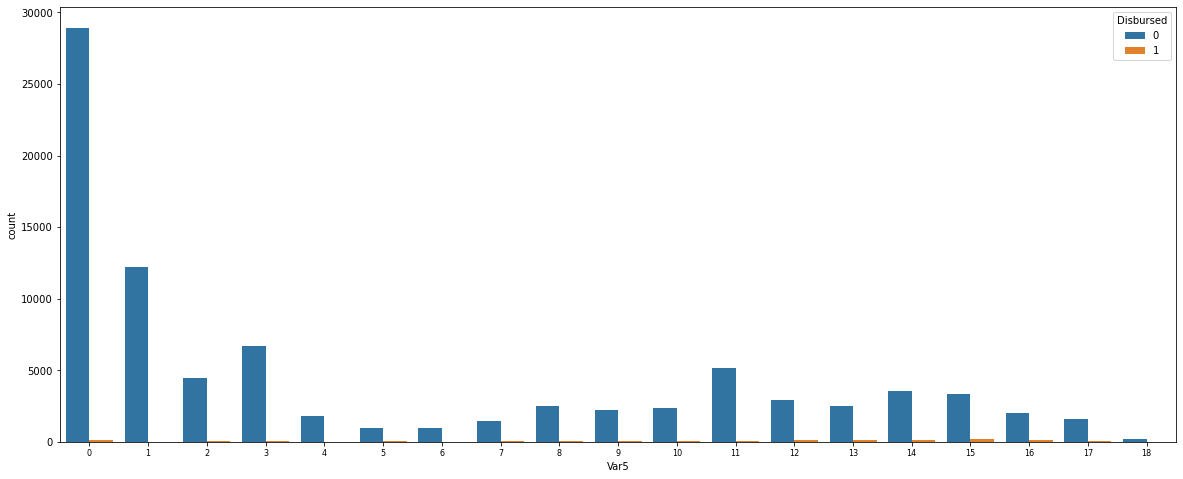

In [124]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Var5", data = train_set, hue="Disbursed")
plt.show()

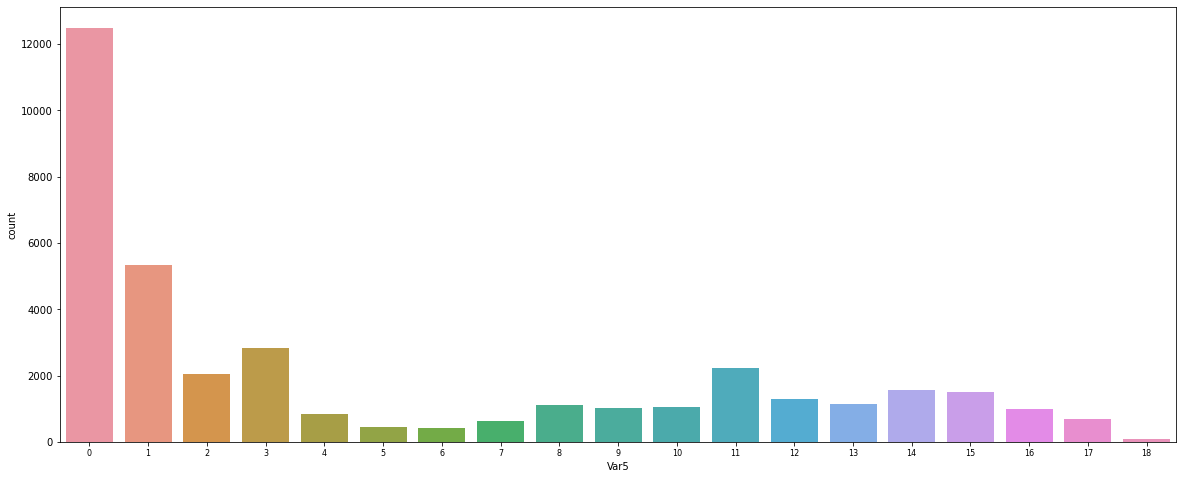

In [125]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Var5", data = test_set)
plt.show()

#### It doesn't seem to be numerical variable

In [126]:
top_2_unique_Salary_Account = train_set.Var5.value_counts()[:2].index.tolist()
print(top_2_unique_Salary_Account)

[0, 1]


In [127]:
under_2_unique_Salary_Account = train_set.Var5.value_counts()[2:].index.tolist()
print(under_2_unique_Salary_Account)

[3, 11, 2, 14, 15, 12, 13, 8, 10, 9, 16, 4, 17, 7, 6, 5, 18]


In [128]:
train_set['Var5'].replace(top_2_unique_Salary_Account, 0, inplace = True)
train_set['Var5'].replace(under_2_unique_Salary_Account, 1, inplace = True)
test_set['Var5'].replace(top_2_unique_Salary_Account, 0, inplace = True)
test_set['Var5'].replace(under_2_unique_Salary_Account, 1, inplace = True)
train_set['Var5'].value_counts()

1    45697
0    41323
Name: Var5, dtype: int64

In [129]:
cat_features.append('Var5')

### Var1- Categorical variable with multiple levels

In [130]:
pd.isnull(train_set['Var1']).value_counts()

False    87020
Name: Var1, dtype: int64

In [131]:
train_set['Var1'].value_counts()

HBXX    59294
HBXC     9010
HBXB     4479
HAXA     2909
HBXA     2123
HAXB     2011
HBXD     1964
HAXC     1536
HBXH      970
HCXF      722
HAYT      508
HAVC      384
HAXM      268
HCXD      237
HCYS      217
HVYS      186
HAZD      109
HCXG       78
HAXF       15
Name: Var1, dtype: int64

In [132]:
train_set['Var1'] = train_set['Var1'].str[:2]
train_set['Var1'].value_counts()

HB    77840
HA     7740
HC     1254
HV      186
Name: Var1, dtype: int64

In [133]:
cat_features.append('Var1')

### Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility

In [134]:
pd.isnull(train_set['Loan_Amount_Submitted']).value_counts()

False    52407
True     34613
Name: Loan_Amount_Submitted, dtype: int64

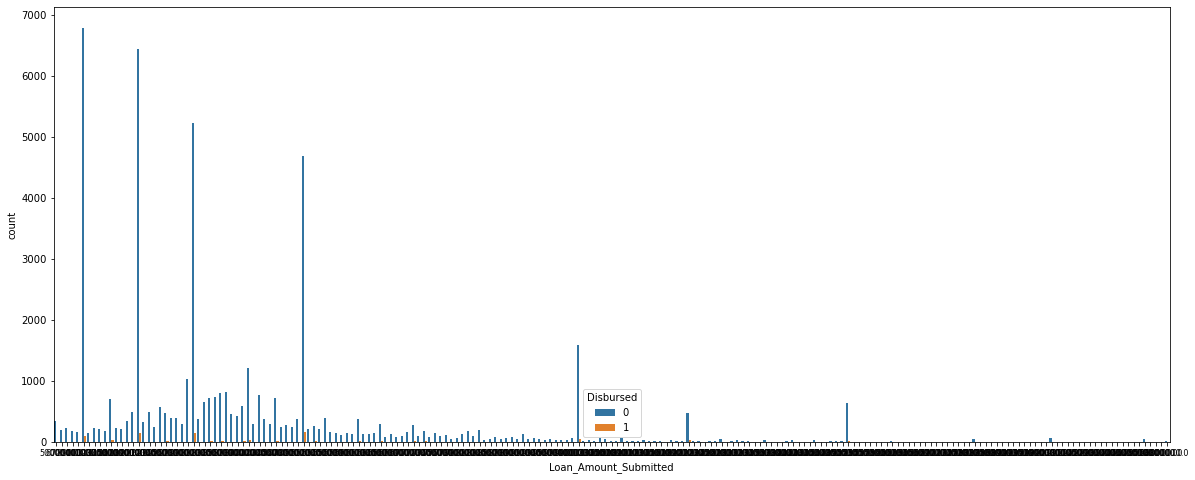

In [135]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Submitted", data = train_set, hue="Disbursed")
plt.show()

In [136]:
train_set['Loan_Amount_Submitted'].value_counts()

100000.0     6884
200000.0     6583
300000.0     5385
500000.0     4849
1000000.0    1644
             ... 
1850000.0       1
2290000.0       1
2480000.0       1
1990000.0       1
2340000.0       1
Name: Loan_Amount_Submitted, Length: 203, dtype: int64

In [137]:
train_set['Loan_Amount_Submitted'].describe()

count    5.240700e+04
mean     3.950106e+05
std      3.082481e+05
min      5.000000e+04
25%      2.000000e+05
50%      3.000000e+05
75%      5.000000e+05
max      3.000000e+06
Name: Loan_Amount_Submitted, dtype: float64

In [138]:
train_set['Loan_Amount_Submitted'].quantile([0, .5, .75, 0.95,1])

0.00      50000.0
0.50     300000.0
0.75     500000.0
0.95    1000000.0
1.00    3000000.0
Name: Loan_Amount_Submitted, dtype: float64

In [139]:
Loan_Amount_Submitted_labels = ['small', 'medium', 'big', 'huge']
train_set['Loan_Amount_Submitted_cut'] = pd.qcut(train_set['Loan_Amount_Submitted'],
                              q=[0, .25, .5, 0.75,1],
                              labels=Loan_Amount_Submitted_labels)
train_set.head()

,ID,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Var4,LoggedIn,Disbursed,Age,Yrs_Lead_Creation_Date,Age_Creation_Date,Loan_Amount_Applied_cut,Loan_Tenure_Applied_cut,Existing_EMI_cut,Loan_Amount_Submitted_cut
0,ID000002C20,Female,1.0,20000,23-May-78,300000.0,5.0,0.0,small,HDFC Bank,...,1,0,0,43,6,37,medium,big,small,NaN
1,ID000004E40,Male,1.0,35000,07-Oct-85,200000.0,2.0,0.0,huge,ICICI Bank,...,3,0,0,36,6,30,medium,medium,small,small
2,ID000007H20,Male,0.0,22500,10-Oct-81,600000.0,4.0,0.0,small,State Bank of India,...,1,0,0,40,6,34,big,medium,small,big
3,ID000008I30,Male,0.0,35000,30-Nov-87,1000000.0,5.0,0.0,small,State Bank of India,...,3,0,0,33,6,27,big,big,small,huge
4,ID000009J40,Male,1.0,100000,17-Feb-84,500000.0,2.0,25000.0,small,HDFC Bank,...,3,1,0,37,6,31,big,medium,big,big


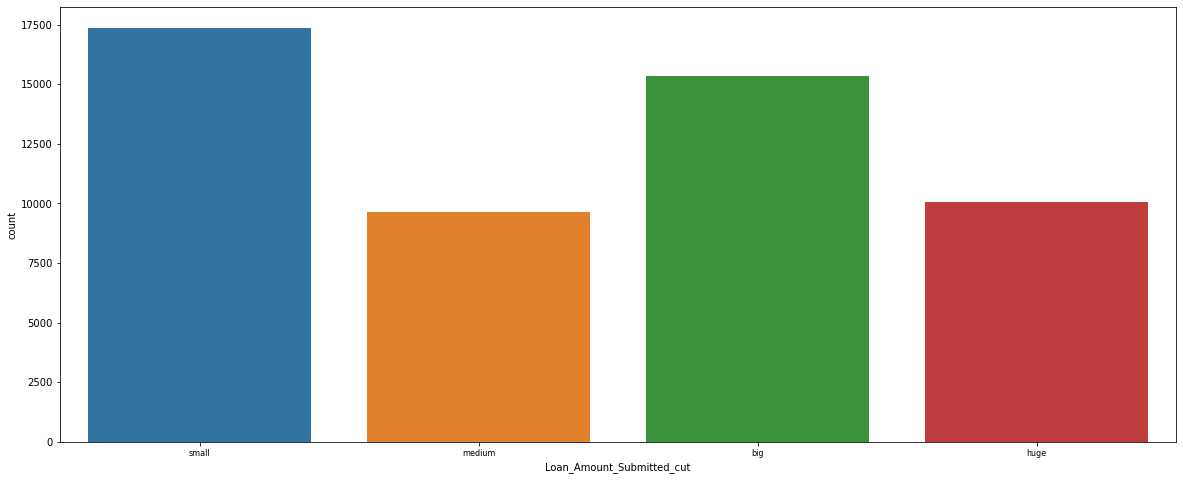

In [140]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Submitted_cut", data = train_set)
plt.show()

In [141]:
train_set['Loan_Amount_Submitted_cut'] = train_set['Loan_Amount_Submitted_cut'].cat.add_categories('Other')
# fill missing values with mean column values
train_set['Loan_Amount_Submitted_cut'].fillna("Other", inplace=True)

In [142]:
cat_features.append('Loan_Amount_Submitted_cut')

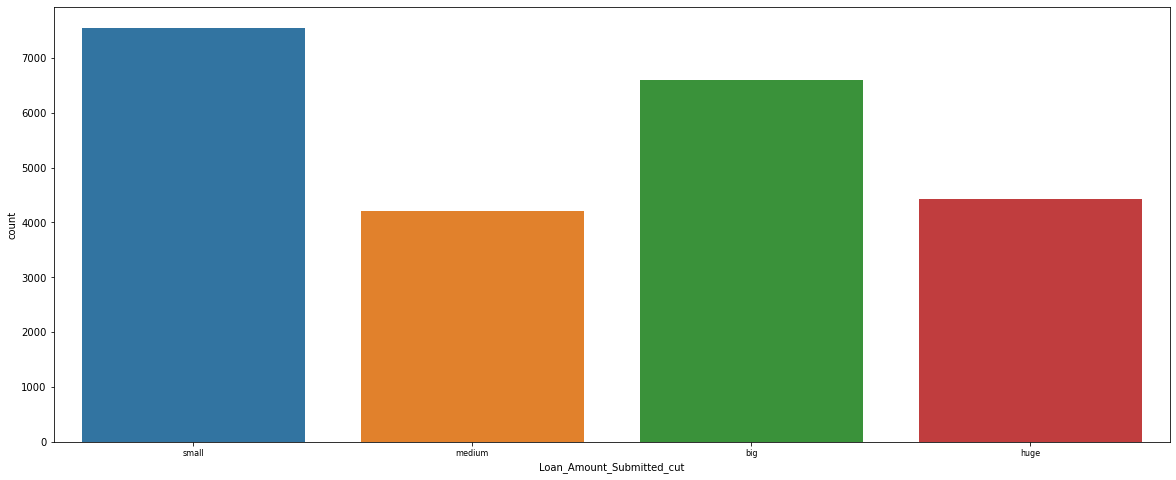

In [143]:
Loan_Amount_Submitted_labels = ['small', 'medium', 'big', 'huge']
test_set['Loan_Amount_Submitted_cut'] = pd.qcut(test_set['Loan_Amount_Submitted'],
                              q=[0, .25, .5, 0.75,1],
                              labels=Loan_Amount_Submitted_labels)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Amount_Submitted_cut", data = test_set)
plt.show()

In [144]:
test_set['Loan_Amount_Submitted_cut'] = test_set['Loan_Amount_Submitted_cut'].cat.add_categories('Other')
# fill missing values with mean column values
test_set['Loan_Amount_Submitted_cut'].fillna("Other", inplace=True)

### Loan_Tenure_Submitted- Loan Tenure Revised and Selected after seeing Eligibility (Years)

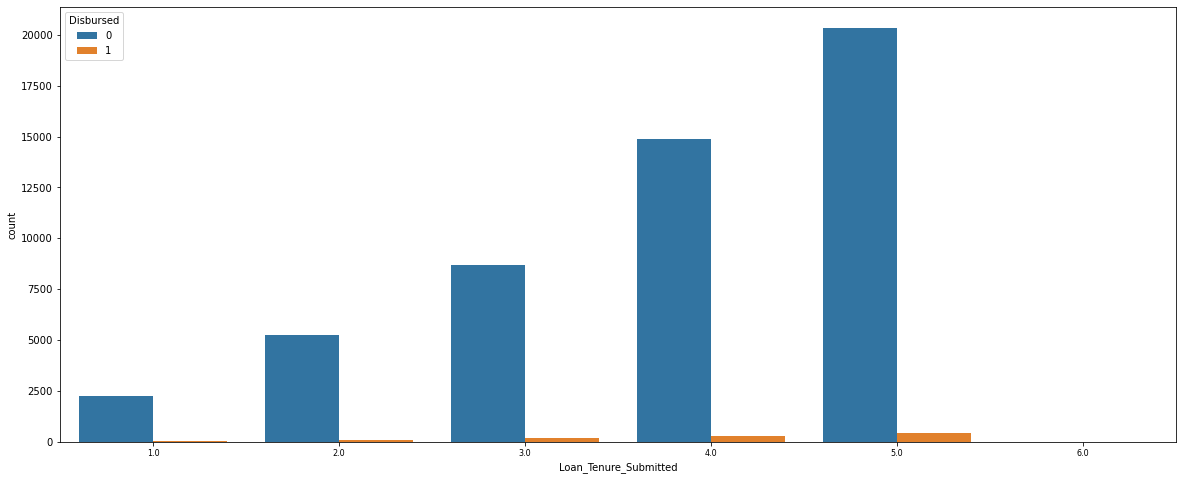

In [145]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Loan_Tenure_Submitted", data = train_set, hue="Disbursed")
plt.show()

In [146]:
pd.isnull(train_set['Loan_Tenure_Submitted']).value_counts()

False    52407
True     34613
Name: Loan_Tenure_Submitted, dtype: int64

In [147]:
train_set['Loan_Tenure_Submitted'].value_counts()

5.0    20765
4.0    15135
3.0     8858
2.0     5332
1.0     2314
6.0        3
Name: Loan_Tenure_Submitted, dtype: int64

In [148]:
# fill missing values 
train_set['Loan_Tenure_Submitted'].fillna("Other", inplace=True)
test_set['Loan_Tenure_Submitted'].fillna("Other", inplace=True)

In [149]:
cat_features.append('Loan_Tenure_Submitted')

### Interest_Rate- Interest Rate of Submitted Loan Amount

In [150]:
pd.isnull(train_set['Interest_Rate']).value_counts()

True     59294
False    27726
Name: Interest_Rate, dtype: int64

Interest_Rate- Interest Rate of Submitted Loan Amount : 19.0


Text(0.5, 0, 'Interest_Rate')

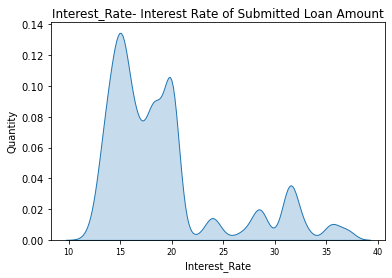

In [151]:
print("Interest_Rate- Interest Rate of Submitted Loan Amount :", np.round(train_set['Interest_Rate'].mean(),0))
sns.kdeplot(data=train_set['Interest_Rate'], shade=True)
plt.title("Interest_Rate- Interest Rate of Submitted Loan Amount")
plt.ylabel('Quantity')
plt.xlabel('Interest_Rate')

In [152]:
# fill missing values with mean column values
train_set['Interest_Rate'].fillna(train_set['Interest_Rate'].mean(), inplace=True)
test_set['Interest_Rate'].fillna(train_set['Interest_Rate'].mean(), inplace=True)

In [153]:
num_features.append('Interest_Rate')

### Processing_Fee- Processing Fee of Submitted Loan Amount (INR)

In [154]:
pd.isnull(train_set['Processing_Fee']).value_counts()

True     59600
False    27420
Name: Processing_Fee, dtype: int64

Processing_Fee- Processing Fee of Submitted Loan Amount (INR): 5131.0


Text(0.5, 0, 'Processing_Fee')

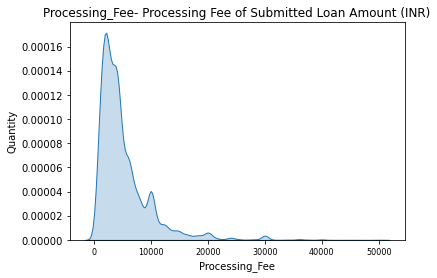

In [155]:
print("Processing_Fee- Processing Fee of Submitted Loan Amount (INR):", np.round(train_set['Processing_Fee'].mean(),0))
sns.kdeplot(data=train_set['Processing_Fee'], shade=True)
plt.title("Processing_Fee- Processing Fee of Submitted Loan Amount (INR)")
plt.ylabel('Quantity')
plt.xlabel('Processing_Fee')

In [156]:
# fill missing values with mean column values
train_set['Processing_Fee'].fillna(train_set['Processing_Fee'].mean(), inplace=True)
test_set['Processing_Fee'].fillna(train_set['Processing_Fee'].mean(), inplace=True)

In [157]:
num_features.append('Processing_Fee')

### EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)

In [158]:
pd.isnull(train_set['EMI_Loan_Submitted']).value_counts()

True     59294
False    27726
Name: EMI_Loan_Submitted, dtype: int64

EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR): 11000.0


Text(0.5, 0, 'EMI_Loan_Submitted')

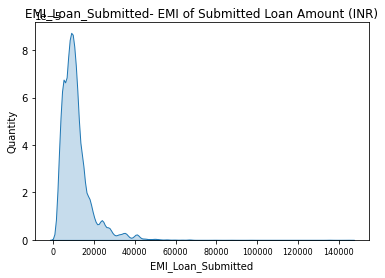

In [159]:
print("EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR):", np.round(train_set['EMI_Loan_Submitted'].mean(),0))
sns.kdeplot(data=train_set['EMI_Loan_Submitted'], shade=True)
plt.title("EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)")
plt.ylabel('Quantity')
plt.xlabel('EMI_Loan_Submitted')

In [160]:
# fill missing values with mean column values
train_set['EMI_Loan_Submitted'].fillna(train_set['EMI_Loan_Submitted'].mean(), inplace=True)
test_set['EMI_Loan_Submitted'].fillna(test_set['EMI_Loan_Submitted'].mean(), inplace=True)

In [161]:
num_features.append('EMI_Loan_Submitted')

### Filled_Form- Filled Application form post quote

##### Filled Form of applying seems to be meaningless variable to the prediction:

In [162]:
train_set = train_set.drop(['Filled_Form'], axis=1)

### Device_Type- Device from which application was made (Browser/ Mobile)

##### Device from someone was applying seems to be meaningless variable to the prediction:

In [163]:
train_set = train_set.drop(['Device_Type'], axis=1)

### Var2- Categorical Variable with multiple Levels

In [164]:
pd.isnull(train_set['Var2']).value_counts()

False    87020
Name: Var2, dtype: int64

In [165]:
train_set['Var2'].value_counts()

B    37280
G    33032
C    14210
E     1315
D      634
F      544
A        5
Name: Var2, dtype: int64

In [166]:
cat_features.append('Var2')

### Source- Categorical Variable with multiple Levels

In [167]:
pd.isnull(train_set['Source']).value_counts()

False    87020
Name: Source, dtype: int64

In [168]:
train_set['Source'].value_counts()

S122    38567
S133    29885
S159     5599
S143     4332
S127     1931
S137     1724
S134     1301
S161      769
S151      720
S157      650
S153      494
S156      308
S144      299
S158      208
S123       73
S141       57
S162       36
S124       24
S160       11
S150       10
S155        4
S139        3
S129        3
S136        3
S138        3
S135        2
S125        1
S140        1
S130        1
S154        1
Name: Source, dtype: int64

In [169]:
train_set['Source'].str[2:]

0        22
1        22
2        43
3        43
4        34
         ..
87015    22
87016    22
87017    22
87018    22
87019    22
Name: Source, Length: 87020, dtype: object

In [170]:
train_set['Source'] = train_set['Source'].str[2:3]
test_set['Source'] = test_set['Source'].str[2:3]

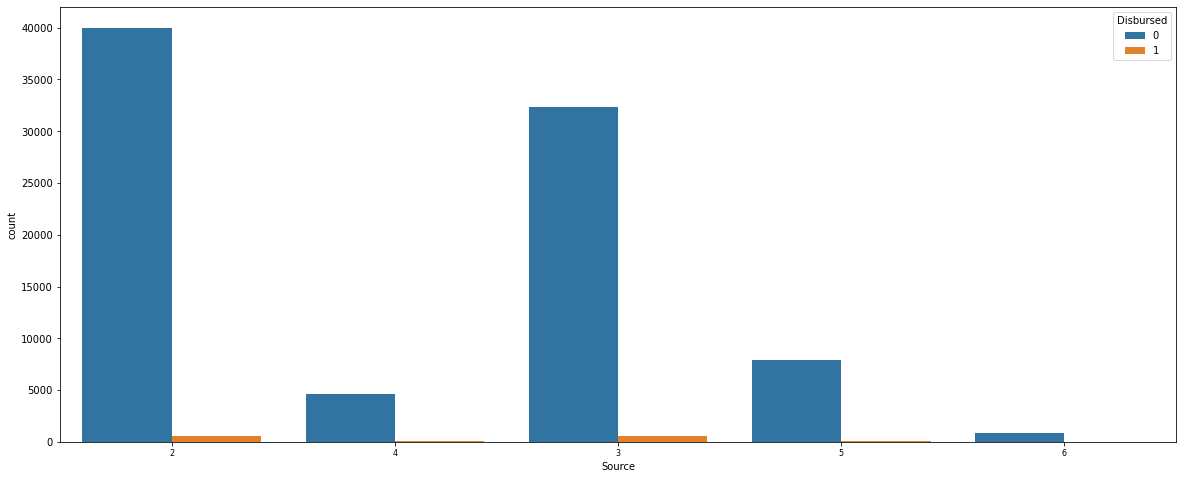

In [171]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Source", data = train_set, hue="Disbursed")
plt.show()

In [172]:
cat_features.append('Source')

### Var4- Categorical Variable with multiple Levels

In [173]:
train_set['Var4'].value_counts()

3    25260
1    23906
5    20266
4     6577
2     5931
0     2546
7     2302
6      232
Name: Var4, dtype: int64

In [174]:
cat_features.append('Var4')

### LoggedIn- Application Logged (Variable for understanding the problem – cannot be used in prediction)

In [175]:
train_set['LoggedIn'].value_counts()

0    84466
1     2554
Name: LoggedIn, dtype: int64

### Disbursed- Loan Disbursed (Target Variable)

In [176]:
train_set['Disbursed'].value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

In [177]:
train_set.isnull().sum()

ID                               0
Gender                           0
City                             0
Monthly_Income                   0
DOB                              0
Loan_Amount_Applied             71
Loan_Tenure_Applied             71
Existing_EMI                    71
Employer_Name                   71
Salary_Account                   0
Mobile_Verified                  0
Var5                             0
Var1                             0
Loan_Amount_Submitted        34613
Loan_Tenure_Submitted            0
Interest_Rate                    0
Processing_Fee                   0
EMI_Loan_Submitted               0
Var2                             0
Source                           0
Var4                             0
LoggedIn                         0
Disbursed                        0
Age                              0
Yrs_Lead_Creation_Date           0
Age_Creation_Date                0
Loan_Amount_Applied_cut          0
Loan_Tenure_Applied_cut          0
Existing_EMI_cut    

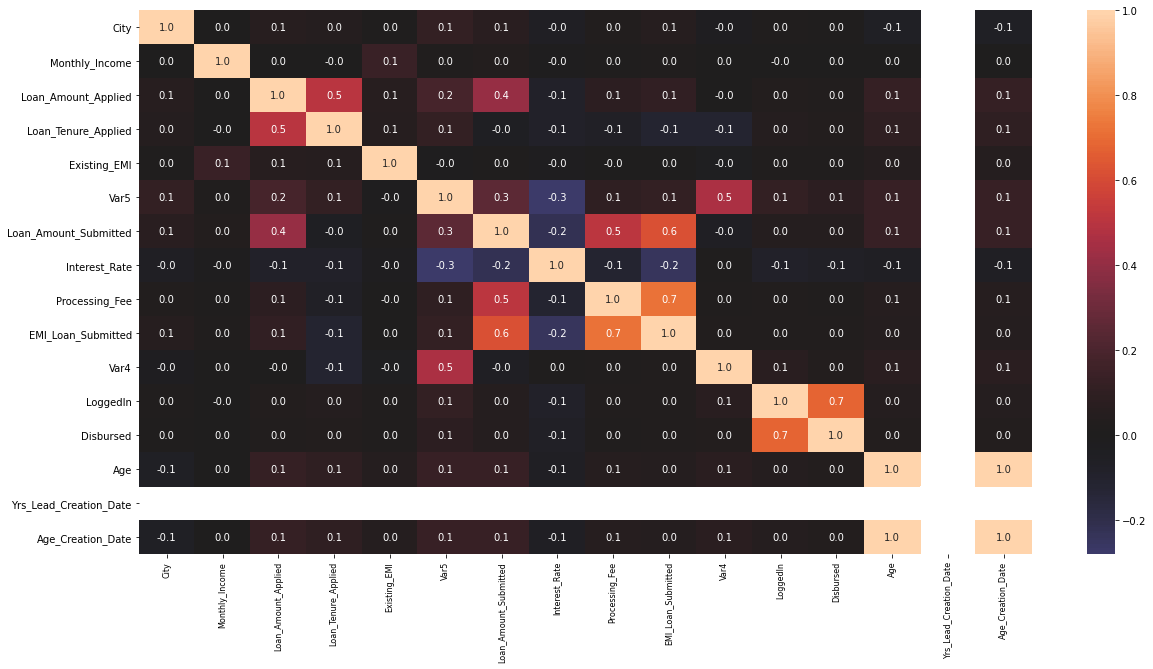

In [178]:
plt.subplots(figsize=(20, 10))
sns.heatmap(train_set.corr(),  annot=True, fmt='.1f', center=0)
plt.show()

#### There is plenty of zero correlated cathegories, but I won't drop it 

In [179]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X = X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns = new_columns, index = X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns

In [180]:
encoder = OneHotEncoder()
encoder_cols = encoder.fit_transform(train_set[cat_features].astype(str))

In [181]:
# Add one-hot encoded columns to numerical features and target column
train_set = pd.concat([pd.concat([train_set[num_features], encoder_cols], axis=1), train_set[target]], axis=1)

In [182]:
train_set.head(3)

,City,Monthly_Income,Age_Creation_Date,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Gender_Female,Gender_Male,Loan_Amount_Applied_cut_big,Loan_Amount_Applied_cut_medium,...,Source_6,Var4_0,Var4_1,Var4_2,Var4_3,Var4_4,Var4_5,Var4_6,Var4_7,Disbursed
0,1.0,20000,37,19.197474,5131.150839,10999.528377,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,35000,30,13.250000,5131.150839,6762.900000,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.0,22500,34,19.197474,5131.150839,10999.528377,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [183]:
features = train_set.columns.tolist()
features.remove(target)
X = train_set[features]
y = train_set[target]

In [184]:
num_features

['City',
 'Monthly_Income',
 'Age_Creation_Date',
 'Interest_Rate',
 'Processing_Fee',
 'EMI_Loan_Submitted']

In [185]:
def ConfusionMatrix(classifier, X=X, y=y, confusionMatrix = True, plotConfusionMatrix = True):
        '''ConfusionMatrix function split data, fit data to model and give 
        a prediction for a given model and data. After that draw Confusion Matrix or 
        Plot Confusion Matrix to show the score'''
        
        #split dataset into train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, 
                                                            stratify=y)

        # Fit the classifier to the data
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        #computing the confusion matrix with each row corresponding to the true class
        if(confusionMatrix):
            print(confusion_matrix(y_test, y_pred))

        #drawing Plot Confusion Matrix
        if(plotConfusionMatrix):
            plot_confusion_matrix(classifier, X_test, y_test)  
            plt.show()

In [186]:
def GridSearch(param, estimator, X=X, y=y, njobs = -1):
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    grid_rf = GridSearchCV(estimator, param, refit = True, verbose = 3, n_jobs=njobs) 

    # fitting the model for grid search 
    grid_rf.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid_rf.best_params_) 
    grid_rf_predictions = grid_rf.predict(X_test) 

    # print classification report 
    print(classification_report(y_test, grid_rf_predictions))

In [187]:
def CVmodel(nFolds = 5, randomState=2020, features=features, lin_reg = False, lin_reg_without_fi = False,
            cutoff=0.5, debug= False, model = SVC(), df = train_set, pipeline = False):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    
    # predictions for individual folds
    predictions = []

    # the index in the original file
    indices = []
    true=[]
    
    if lin_reg:
        for train, test in kf.split(df.index.values):
            if debug:
                print(model)
            model.fit(df.iloc[train][features], df.iloc[train][target])

            # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
            # preds = model.predict_proba(df.iloc[test][features])[:,1]
            preds, y_test = model.predict(df.iloc[test][features], round(cutoff,1))
            
            # information about predictions for this fold
            predictions.append(preds.tolist().copy())
            # indexed in the original data frame
            indices.append(df.iloc[test].index.tolist().copy())
            
            true = (df.iloc[test][target]==1)
            if(lin_reg_without_fi == False):
                feature_importance = model.coef_
        if(lin_reg_without_fi):
            return predictions, indices, true
            
        return predictions, indices, feature_importance, true
        
        
    if(pipeline):
        for train, test in kf.split(df.index.values):
            if debug:
                print(model)
            model.fit(df.iloc[train][features], df.iloc[train][target])

            # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
            preds = model.predict_proba(df.iloc[test][features])[:,1]

            # information about predictions for this fold
            predictions.append(preds.tolist().copy())

            # indexed in the original data frame
            indices.append(df.iloc[test].index.tolist().copy())
        
        return predictions, indices, true
        
    for train, test in kf.split(df.index.values):
        if debug:
            print(model)
        model.fit(df.iloc[train][features], df.iloc[train][target])

        # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]

        # information about predictions for this fold
        predictions.append(preds.tolist().copy())

        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())

        true.append(df.iloc[test][target]==1)

        feature_importance = model.feature_importances_
        
    return predictions, indices, feature_importance, true

In [188]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [189]:
param = {'max_depth': [10, 50, 100],
         'n_estimators': [100, 500],
         'max_features': [10 , 20]}

#GridSearch(param = param, estimator = RandomForestClassifier())

In [190]:
rf = RandomForestClassifier()

In [191]:
gd = GridSearchCV(estimator = rf, param_grid = param)

In [192]:
gd.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 50, 100], 'max_features': [10, 20],
                         'n_estimators': [100, 500]})

In [193]:
print(gd.best_params_)
print(gd.best_score_)

{'max_depth': 10, 'max_features': 10, 'n_estimators': 100}
0.9853051026758717


In [194]:
param = {'max_depth': [2, 5],
         'n_estimators': [50, 100],
         'max_features': [5, 10],
         'min_samples_split': [10, 30]}

#GridSearch(param=param, estimator=RandomForestClassifier())

In [195]:
gd = GridSearchCV(estimator = rf, param_grid = param)

In [196]:
gd.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5], 'max_features': [5, 10],
                         'min_samples_split': [10, 30],
                         'n_estimators': [50, 100]})

In [197]:
print(gd.best_params_)
print(gd.best_score_)

{'max_depth': 2, 'max_features': 5, 'min_samples_split': 10, 'n_estimators': 50}
0.9853051026758717


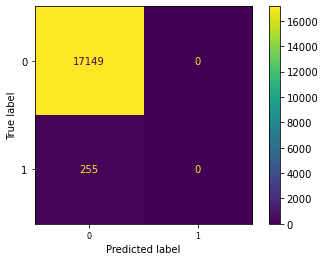

In [198]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(classifier=rand_forest, confusionMatrix=False)

### The model predicts incorrectly for 1 category. This is due to unbalanced data.

## improving the quality of classification of models built on unsustainable training sets

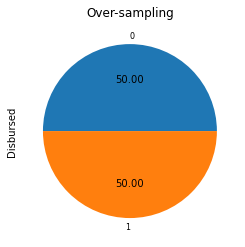

In [199]:
from imblearn.over_sampling import RandomOverSampler

#fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = "%.2f"
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
ax = y_res.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Over-sampling")

In [200]:
param = {'max_depth': [2, 5],
         'n_estimators': [50, 100],
         'max_features': [5, 10],
         'min_samples_split': [10, 30]}

In [201]:
gd = GridSearchCV(estimator = rf, param_grid = param)

In [202]:
gd.fit(X_res, y_res)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5], 'max_features': [5, 10],
                         'min_samples_split': [10, 30],
                         'n_estimators': [50, 100]})

In [203]:
print(gd.best_params_)
print(gd.best_score_)

{'max_depth': 5, 'max_features': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.7441018405521416


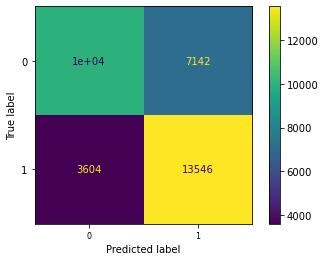

In [204]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_res, y=y_res)

In [205]:
from sklearn.model_selection import cross_validate
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}
scoring = ["accuracy", "balanced_accuracy"]

index += ["RandomOverSampler +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_res, y_res, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363


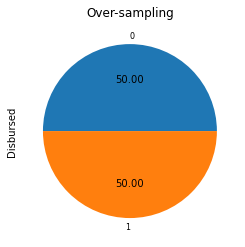

In [206]:
from imblearn.over_sampling import SMOTE

#fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = "%.2f"
s = SMOTE(random_state=0)
X_s, y_s = s.fit_resample(X, y)
ax = y_s.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Over-sampling")

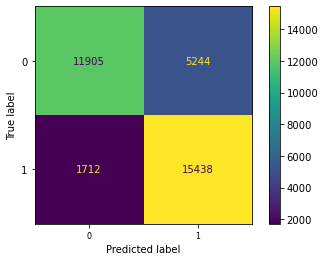

In [207]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_s, y=y_s)

In [208]:
index += ["SMOTE+  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_s, y_s, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325


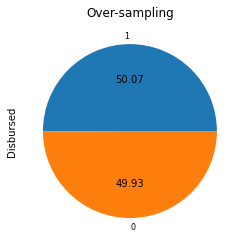

In [209]:
from imblearn.over_sampling import ADASYN

#fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = "%.2f"
s = ADASYN(random_state=0)
X_a, y_a = s.fit_resample(X, y)
ax = y_a.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Over-sampling")

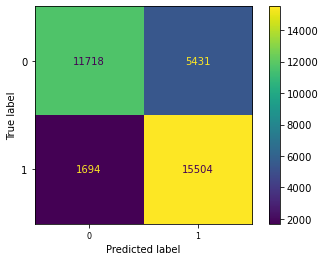

In [210]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_a, y=y_a)

In [211]:
index += ["ADASYN +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_a, y_a, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704


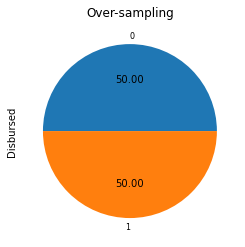

In [212]:
from imblearn.over_sampling import BorderlineSMOTE

bs = BorderlineSMOTE(random_state=0)
X_bs, y_bs = bs.fit_resample(X, y)
ax = y_bs.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Over-sampling")

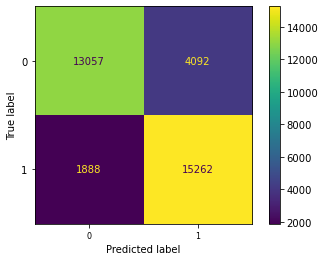

In [213]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_bs, y=y_bs)

In [214]:
index += ["BorderlineSMOTE +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_bs, y_bs, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704
BorderlineSMOTE + RandomForestClassifier,0.805544,0.805545


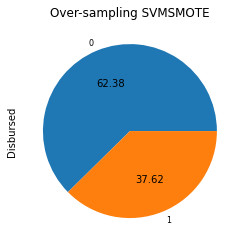

In [215]:
from imblearn.over_sampling import SVMSMOTE

svms = SVMSMOTE(random_state=0)
X_svms, y_svms = svms.fit_resample(X, y)
ax = y_svms.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Over-sampling SVMSMOTE")

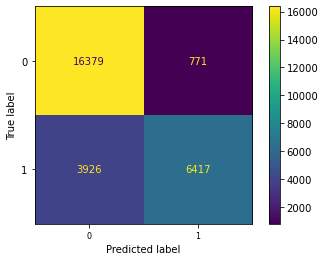

In [216]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_svms, y=y_svms)

In [217]:
index += ["SVMSMOTE +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_svms, y_svms, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704
BorderlineSMOTE + RandomForestClassifier,0.805544,0.805545
SVMSMOTE + RandomForestClassifier,0.810118,0.773461


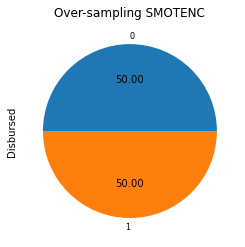

In [218]:
from imblearn.over_sampling import SMOTENC
smotenc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_smotenc, y_smotenc = smotenc.fit_resample(X, y)
ax = y_smotenc.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Over-sampling SMOTENC")

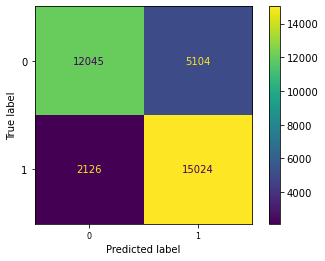

In [219]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_smotenc, y=y_smotenc)

In [220]:
index += ["SMOTENC +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_smotenc, y_smotenc, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704
BorderlineSMOTE + RandomForestClassifier,0.805544,0.805545
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
SMOTENC + RandomForestClassifier,0.755648,0.755648


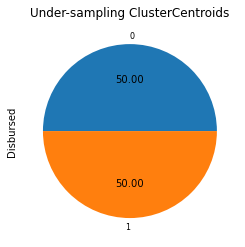

In [221]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X, y)
ax = y_cc.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Under-sampling ClusterCentroids")

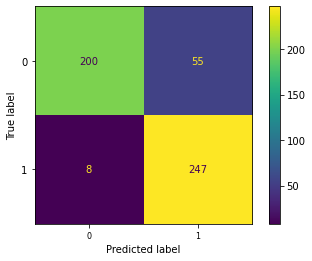

In [222]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_cc, y=y_cc)

In [223]:
index += ["ClusterCentroids +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_cc, y_cc, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704
BorderlineSMOTE + RandomForestClassifier,0.805544,0.805545
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
SMOTENC + RandomForestClassifier,0.755648,0.755648
ClusterCentroids + RandomForestClassifier,0.877087,0.877080


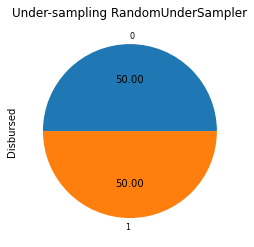

In [224]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
ax = y_rus.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Under-sampling RandomUnderSampler")

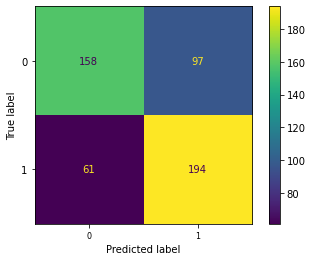

In [225]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_rus, y=y_rus)

In [226]:
index += ["RandomUnderSampler +  RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_rus, y_rus, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
RandomOverSampler + RandomForestClassifier,0.680362,0.680363
SMOTE+ RandomForestClassifier,0.764324,0.764325
ADASYN + RandomForestClassifier,0.783875,0.783704
BorderlineSMOTE + RandomForestClassifier,0.805544,0.805545
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
SMOTENC + RandomForestClassifier,0.755648,0.755648
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
RandomUnderSampler + RandomForestClassifier,0.678310,0.678339


#### The best results have SVMSMOTE as Over-sampling and ClusterCentroids as Under-sampling 

In [227]:
index2 = []
scores2 = {"Accuracy": [], "Balanced accuracy": []}
scoring2 = ["accuracy", "balanced_accuracy"]

#X_svms, y_svms SVMSMOTE
#X_cc, y_cc ClusterCentroids 

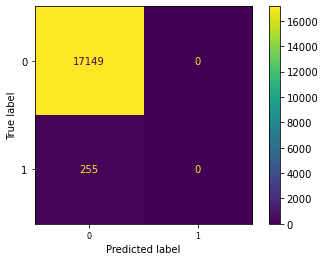

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.5


In [228]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X, y=y)
index2 += ["RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X, y, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

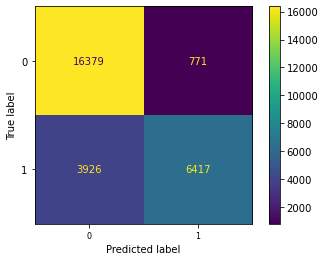

In [229]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_svms, y=y_svms)

In [230]:
index2 += ["SVMSMOTE + RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461


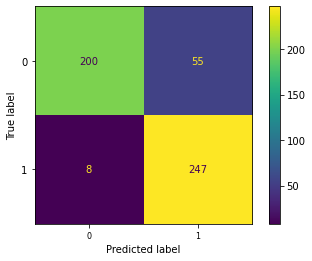

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080


In [231]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=50, 
                                 max_depth=2, max_features=5, min_samples_split=10)

ConfusionMatrix(rand_forest, confusionMatrix=False, X=X_cc, y=y_cc)

index2 += ["ClusterCentroids + RandomForestClassifier"]
cv_result = cross_validate(rand_forest, X_cc, y_cc, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


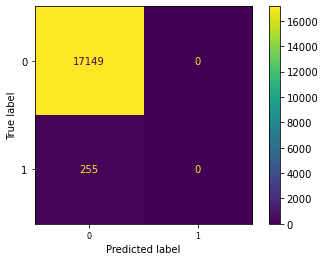

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000


In [232]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
#Standardization of data and KNN model 
logreg_scaler = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())
                ])
ConfusionMatrix(classifier=logreg_scaler, confusionMatrix=False)
index2 += ["LogisticRegression"]
cv_result = cross_validate(rand_forest, X, y, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

In [233]:
index2 += ["SVMSMOTE + LogisticRegression"]
cv_result = cross_validate(rand_forest, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000
SVMSMOTE + LogisticRegression,0.810118,0.773461


In [234]:
index2 += ["ClusterCentroids + LogisticRegression"]
cv_result = cross_validate(rand_forest, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000
SVMSMOTE + LogisticRegression,0.810118,0.773461
ClusterCentroids + LogisticRegression,0.810118,0.773461


In [235]:
#Standardization of data and KNN model 
pipe = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())
                ])

param = {'knn__n_neighbors': [10, 100],
         'knn__weights': ['uniform', 'distance'],
         'knn__p': [1, 2]}

GridSearch(param=param, estimator=pipe)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21429
           1       0.00      0.00      0.00       326

    accuracy                           0.99     21755
   macro avg       0.49      0.50      0.50     21755
weighted avg       0.97      0.99      0.98     21755



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [236]:
#Standardization of data and KNN model 
pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())
                ])

param = {'knn__n_neighbors': [10, 50],
         'knn__weights': ['uniform'],
         'knn__p': [1]}

GridSearch(param=param, estimator=pipe)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21429
           1       0.00      0.00      0.00       326

    accuracy                           0.99     21755
   macro avg       0.49      0.50      0.50     21755
weighted avg       0.97      0.99      0.98     21755



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


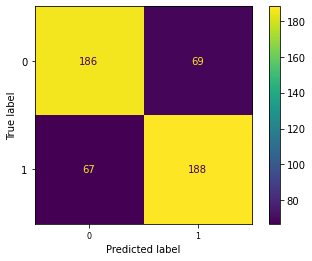

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000
SVMSMOTE + LogisticRegression,0.810118,0.773461
ClusterCentroids + LogisticRegression,0.810118,0.773461
KNeighborsClassifier,0.959473,0.962980


In [237]:
#KNeighborsClassifier model 
knn =  KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform')

ConfusionMatrix(knn, confusionMatrix=False, X=X_cc, y=y_cc)

index2 += ["KNeighborsClassifier"]
cv_result = cross_validate(knn, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

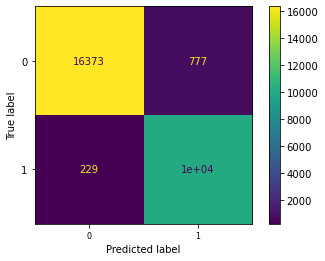

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000
SVMSMOTE + LogisticRegression,0.810118,0.773461
ClusterCentroids + LogisticRegression,0.810118,0.773461
KNeighborsClassifier,0.959473,0.962980
SVMSMOTE + KNeighborsClassifier,0.959473,0.962980


In [238]:
#KNeighborsClassifier model 
knn =  KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform')

ConfusionMatrix(knn, confusionMatrix=False, X=X_svms, y=y_svms)

index2 += ["SVMSMOTE + KNeighborsClassifier"]
cv_result = cross_validate(knn, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

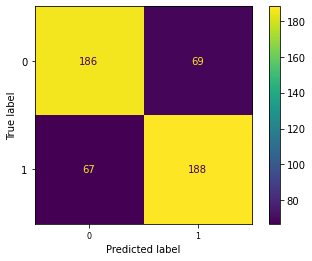

,Accuracy,Balanced accuracy
RandomForestClassifier,0.985371,0.500000
SVMSMOTE + RandomForestClassifier,0.810118,0.773461
ClusterCentroids + RandomForestClassifier,0.877087,0.877080
LogisticRegression,0.985371,0.500000
SVMSMOTE + LogisticRegression,0.810118,0.773461
ClusterCentroids + LogisticRegression,0.810118,0.773461
KNeighborsClassifier,0.959473,0.962980
SVMSMOTE + KNeighborsClassifier,0.959473,0.962980
ClusterCentroids + KNeighborsClassifier,0.745469,0.745470


In [239]:
#KNeighborsClassifier model 
knn =  KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform')

ConfusionMatrix(knn, confusionMatrix=False, X=X_cc, y=y_cc)

index2 += ["ClusterCentroids + KNeighborsClassifier"]
cv_result = cross_validate(knn, X_cc, y_cc, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

In [252]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [241]:
import xgboost as xgb
# split into a training and testing set
pipe = Pipeline(steps=[
                ('xgb', xgb())
                ])

param = {'xgb__nthread':[4], #when use hyperthread, xgboost may become slower
              'xgb__objective':['binary:logistic'],
              'xgb__learning_rate': [0.05], #so called `eta` value
              'xgb__max_depth': [6],
              'xgb__min_child_weight': [11],
              'xgb__silent': [1],
              'xgb__subsample': [0.8],
              'xgb__colsample_bytree': [0.7],
              'xgb__n_estimators': [5], #number of trees, change it to 1000 for better results
              'xgb__missing':[-999],
              'xgb__seed': [1337]}

GridSearch(param=param, estimator=pipe)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [ ]:
from sklearn.svm import SVC
# split into a training and testing set
pipe = Pipeline(steps=[
                ('svc', SVC())
                ])

param = {'svc__C': [1, 10],
         'svc__kernel': ['linear', 'poly']}

GridSearch(param=param, estimator=pipe, njobs = 1)

In [ ]:
# split into a training and testing set
pipe = Pipeline(steps=[
                ('xgb', xgb())
                ])

param = {'svc__kernel': ['linear', 'rbf'],
         'svc__gamma': ['scale', 'auto']
        }

GridSearch(param=param, estimator=pipe)

In [ ]:
#SVC model 
svm =  SVC(kernel='linear', C=1, gamma='scale', probability=True)

ConfusionMatrix(knn, confusionMatrix=False, X=X, y=y)

index2 += ["SVC"]
cv_result = cross_validate(svm, X, y, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

In [ ]:
#SVC model 
svm =  SVC(kernel='linear', C=1, gamma='scale', probability=True)

ConfusionMatrix(knn, confusionMatrix=False, X=X_svms, y=y_svms)

index2 += ["SVMSMOTE + SVC"]
cv_result = cross_validate(svm, X_svms, y_svms, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2

In [ ]:
#SVC model 
svm =  SVC(kernel='linear', C=1, gamma='scale', probability=True)

ConfusionMatrix(knn, confusionMatrix=False, X=X_cc, y=y_cc)

index2 += ["ClusterCentroids + SVC"]
cv_result = cross_validate(svm, X_cc, y_cc, scoring=scoring2)
scores2["Accuracy"].append(cv_result["test_accuracy"].mean())
scores2["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores2 = pd.DataFrame(scores2, index=index2)
df_scores2